### Описание данных

- В распоряжении имеются шесть табличных файлов Excel, в каждом статистика по одному году. Временной период - с 2015 по июль 2020 года. Также есть файл с численностью основных производственных рабочих (ОПР) с 2017 по июль 2020 года.
- Файлы содержат статистику освоения трудоемкости в нормочасах по заказам, цехам и профессиям машиностроительного предприятия. Данные реальные. 
- Структура всех таблиц с фактической трудоемкостью одинакова и содержит следующие столбцы:
  - **"Дата"** - первые числа каждого месяца года;
  - **"Цех"** - номер выпускающего / заготовительного цеха;
  - **"Заказ"** - семи- или девятизначный порядковый номер, присвоенный заказу. Также в этом столбце может быть шум: вместо номеров могут быть наименования заказов. Такие заказы - это не основное производство, а оснастка либо ремонты. Их можно заменить универсальным номером заказа **1200000** в случае оснастки либо **3000000** в случае ремонтов;
  - **"К-т"** - номер комплекта. В случае изготовления заказа в одном экземпляре номер комплекта указывается 1. Пропуски в этом столбце, как правило, относятся к заказам оснастки либо ремонтов;
  - **"Профессия"** - наименование профессии, на которую закрыт наряд по фактической трудоемкости. В этом же столбце через запятую указан шифр профессии по общероссийскому классификатору. Данные столбца будут использоваться для более подробного разделения освоенной трудоемкости по цехам и переделам;
  - **"Трудоемкость"** - количество нормочасов, потраченных на изготовление заказа определенного комплекта в определенном цехе определенным исполнителем в определенный месяц.
- Номера заказов основного пула начинаются на 20. Номера заказов оснастки начинаются на 12, а ремонты и прочие - на 22, 30, 33 и прочие. 

In [1]:
import pandas as pd
import math
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from pymystem3 import Mystem
import matplotlib.dates as mdates
m = Mystem()

In [2]:
#!pip install sorted-months-weekdays
#!pip install sort-dataframeby-monthorweek

In [3]:
from sorted_months_weekdays import *
from sort_dataframeby_monthorweek import *

В этом проекте будет несколько файлов. Статистика по трудоемкости за каждый год выгружена отдельным файлом. Временной диапазон - с 2015 по июль 2020, 5.5 лет. Файлы будем открывать и приводить в порядок по одному.

### Откроем файл за 2015 год и проведем предобработку

In [4]:
uxm2015 = pd.read_excel('uxm2015.xlsx')
uxm2015.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
0,01.01.2015 0:00:00,NaN,NaN,NaN,NaN,31092.762
1,01.01.2015 0:00:00,15.0,NaN,NaN,NaN,13350.377
2,01.01.2015 0:00:00,15.0,2066633,18.0,"РАЗМЕТЧИК, 17636",0.120
3,01.01.2015 0:00:00,15.0,2066633,19.0,"РАЗМЕТЧИК, 17636",0.120
4,01.01.2015 0:00:00,15.0,1215332,NaN,"РАЗМЕТЧИК, 17636",0.060


In [5]:
uxm2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310846 entries, 0 to 310845
Data columns (total 6 columns):
Дата            310846 non-null object
Цех             310845 non-null float64
Заказ           302406 non-null object
К-т             293645 non-null float64
Профессия       310791 non-null object
Трудоемкость    310797 non-null float64
dtypes: float64(3), object(3)
memory usage: 14.2+ MB


In [6]:
# Функция, которая показывает, каков процент пропущенных значений в каждом столбце таблицы
def percent_missing(df):
    percents = df.isnull().sum()*100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percents})
    return missing_value_df

In [7]:
percent_missing(uxm2015)

,column_name,percent_missing
Дата,Дата,0.000000
Цех,Цех,0.000322
Заказ,Заказ,2.715171
К-т,К-т,5.533608
Профессия,Профессия,0.017694
Трудоемкость,Трудоемкость,0.015763


Короткие выводы: 
- столбцы даты, цеха и комплекта требуют смены типа: дату нужно привести к формату даты, а номера цеха и комплекта не могут быть дробными. 
- В столбце **"Заказ"** также должны быть только номера заказов, из него нужно удалить все строки, в которых вместо номера заказа указано его название - это заказы оснастки или ремонтов, которые не учитываются в общем расчете загрузки. 
- Также есть пропуски. Их нужно обработать по каждому столбцу отдельно. Начнем со столбца **"Цех"**.

In [8]:
uxm2015[uxm2015['Цех'].isnull()]

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
0,01.01.2015 0:00:00,NaN,NaN,NaN,NaN,31092.762


Номер цеха пропущен только в первой строке. Файлы выгружены из 1С, отчет настроен таким образом, что в первой строке указана суммарно освоенная трудоемкость за первый месяц. Эту строку можно удалить.

In [9]:
uxm2015 = uxm2015.dropna(subset=['Цех'])
uxm2015.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
1,01.01.2015 0:00:00,15.0,NaN,NaN,NaN,13350.377
2,01.01.2015 0:00:00,15.0,2066633,18.0,"РАЗМЕТЧИК, 17636",0.120
3,01.01.2015 0:00:00,15.0,2066633,19.0,"РАЗМЕТЧИК, 17636",0.120
4,01.01.2015 0:00:00,15.0,1215332,NaN,"РАЗМЕТЧИК, 17636",0.060
5,01.01.2015 0:00:00,15.0,1263033,NaN,"РАЗМЕТЧИК, 17636",0.080


In [10]:
uxm2015[uxm2015['Профессия'].isnull()]

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
1,01.01.2015 0:00:00,15.0,NaN,NaN,NaN,13350.3770
4635,01.01.2015 0:00:00,23.0,NaN,NaN,NaN,7706.2640
16315,01.01.2015 0:00:00,40.0,NaN,NaN,NaN,10036.1210
17994,01.02.2015 0:00:00,40.0,NaN,NaN,NaN,30655.9370
17995,01.02.2015 0:00:00,15.0,NaN,NaN,NaN,9415.6720
21945,01.02.2015 0:00:00,23.0,NaN,NaN,NaN,9628.9800
36034,01.02.2015 0:00:00,40.0,NaN,NaN,NaN,11611.2850
38046,01.03.2015 0:00:00,40.0,NaN,NaN,NaN,41270.2175
38047,01.03.2015 0:00:00,15.0,NaN,NaN,NaN,15876.4795
44314,01.03.2015 0:00:00,23.0,NaN,NaN,NaN,12726.7700


In [11]:
len(uxm2015[uxm2015['Профессия'].isnull()])

54

Опять же исходя из структуры отчета в 1С, откуда была выгружена таблица, понятно, что строки с пропусками в столбце "Профессия" – это итоговые строки для каждого цеха по месяцам. Их нужно удалить.

In [12]:
uxm2015 = uxm2015.dropna(subset=['Профессия'])
uxm2015.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
2,01.01.2015 0:00:00,15.0,2066633,18.0,"РАЗМЕТЧИК, 17636",0.12
3,01.01.2015 0:00:00,15.0,2066633,19.0,"РАЗМЕТЧИК, 17636",0.12
4,01.01.2015 0:00:00,15.0,1215332,NaN,"РАЗМЕТЧИК, 17636",0.06
5,01.01.2015 0:00:00,15.0,1263033,NaN,"РАЗМЕТЧИК, 17636",0.08
6,01.01.2015 0:00:00,15.0,205506404,1.0,"РАЗМЕТЧИК, 17636",0.02


Теперь посмотрим на пропуски в столбце "К-т". По логике это должны быть строки с заказами оснастки, ремонтов и тд. 

In [13]:
uxm2015[uxm2015['К-т'].isnull()]

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
4,01.01.2015 0:00:00,15.0,1215332,NaN,"РАЗМЕТЧИК, 17636",0.06
5,01.01.2015 0:00:00,15.0,1263033,NaN,"РАЗМЕТЧИК, 17636",0.08
16,01.01.2015 0:00:00,15.0,Гидростенды ц.15,NaN,"СВЕРЛОВЩИК, 18355",0.21
17,01.01.2015 0:00:00,15.0,Гидростенды ц.15,NaN,"СВЕРЛОВЩИК, 18355",0.80
21,01.01.2015 0:00:00,15.0,1215333,NaN,"РАЗМЕТЧИК, 17636",0.08
...,...,...,...,...,...,...
310716,01.12.2015 0:00:00,40.0,NaN,NaN,"УКЛАДЧИК-УПАКОВЩИК, 19293",17.86
310717,01.12.2015 0:00:00,40.0,NaN,NaN,"УКЛАДЧИК-УПАКОВЩИК, 19293",8.05
310718,01.12.2015 0:00:00,40.0,NaN,NaN,"МАЛЯР, 13450",75.78
310719,01.12.2015 0:00:00,40.0,NaN,NaN,"МАЛЯР, 13450",75.78


17146 пропусков - это немало. Нужно составить представление о том, какие номера заказов попали в эти строки.

In [14]:
uxm2015[uxm2015['К-т'].isnull()]['Заказ'].unique()

array([1215332, 1263033, 'Гидростенды ц.15', 1215333, 1263037, 1256282,
       nan, 1255060, 1252019, '205506405-150/195-1430', 1248521, 1248527,
       1252020, 1210638, 1263039, 1263040, 1263038, 1262404, 1294983,
       1263035, 1263036, 1263041, 1266633, 1215339, 1255065, 1255066,
       1255063, 1262405, 1262403, 1263034, 'Гидростенды ц.40', 1215334,
       1256295, 1256294, 1256293, '2063037-150/7-30', 1215337,
       '2056282-150/20-50', '2056282-150/21-51', '2045304-150/12-53',
       '2045303-150/15-52', 1255064, 1267095, '3030150 №4118', 1243870,
       'Реконструкция печи с выкатным подоном  6,4*18 ц40',
       '2063034-400/8-43', '2063034-400/10-42', '2063034-400/294-37',
       1215338, 'Горизонтально-расточный станок SPIRIT 400 ц.40', 1215335,
       '2045151-400/28-90', '205201931-150/42-100', 1231017, 1231018,
       1255069, 1215336, '3032230 №4277', 1210639,
       'Исследование и работы по оптимизации затрат по изготовл. шаровых резервуаров 600-6600м3',
       '20666

Судя по всему, никаких основных заказов в списке нет. Номера вида 20XXXXX-YYY/YYY-YYY - это тоже оснастка. Удалять строки с пропусками в столбце "К-т" нельзя, но так как все эти заказы - либо оснастка, либо ремонты, то можно заполнить пропуски единицами. Логика такова, что все заказы оснастки мы покажем под единым номером заказокомплекта **"1200000 к-т 1"**, а ремонтов и прочих подобных внутренних заказов - под единым номером **"3000000 к-т 1"**. Это позволит убрать лишний шум из данных и консолидировать все внутренние работы в понятной категории.

In [15]:
uxm2015[['К-т']] = uxm2015[['К-т']].fillna(value=1)
uxm2015.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
2,01.01.2015 0:00:00,15.0,2066633,18.0,"РАЗМЕТЧИК, 17636",0.12
3,01.01.2015 0:00:00,15.0,2066633,19.0,"РАЗМЕТЧИК, 17636",0.12
4,01.01.2015 0:00:00,15.0,1215332,1.0,"РАЗМЕТЧИК, 17636",0.06
5,01.01.2015 0:00:00,15.0,1263033,1.0,"РАЗМЕТЧИК, 17636",0.08
6,01.01.2015 0:00:00,15.0,205506404,1.0,"РАЗМЕТЧИК, 17636",0.02


Наконец, посмотрим на пропуски в столбце "Заказ".

In [16]:
uxm2015[uxm2015['Заказ'].isnull()]

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
493,01.01.2015 0:00:00,15.0,NaN,1.0,"СВЕРЛОВЩИК, 18355",0.40
494,01.01.2015 0:00:00,15.0,NaN,1.0,"СВЕРЛОВЩИК, 18355",0.40
1041,01.01.2015 0:00:00,15.0,NaN,1.0,"ФРЕЗЕРОВЩИК, 19479",20.82
2294,01.01.2015 0:00:00,15.0,NaN,1.0,"УКЛАДЧИК-УПАКОВЩИК, 19293",2.05
2295,01.01.2015 0:00:00,15.0,NaN,1.0,"УКЛАДЧИК-УПАКОВЩИК, 19293",2.05
...,...,...,...,...,...,...
310715,01.12.2015 0:00:00,40.0,NaN,1.0,"УКЛАДЧИК-УПАКОВЩИК, 19293",17.65
310716,01.12.2015 0:00:00,40.0,NaN,1.0,"УКЛАДЧИК-УПАКОВЩИК, 19293",17.86
310717,01.12.2015 0:00:00,40.0,NaN,1.0,"УКЛАДЧИК-УПАКОВЩИК, 19293",8.05
310718,01.12.2015 0:00:00,40.0,NaN,1.0,"МАЛЯР, 13450",75.78


К сожалению, из имеющихся данных невозможно сделать вывод, к какой категории можно отнести указанную в этих строках трудоемкость - к оснастке или ремонтам. Просто заполнить предыдущими значениями в столбце - неправильно, поскольку нет уверенности, что речь идет именно о таком случае, когда один номер заказа относится к нескольким строкам подряд, а указан только в первой из них. Для интереса можно посмотреть, о каком объеме работ вообще идет речь в этих восьми тысячах строк.

In [17]:
uxm2015[uxm2015['Заказ'].isnull()]['Трудоемкость'].sum()

27557.9964

27.5 тысяч нормочасов за год. Учитывая, что за месяц завод закрывает порядка 50-60 тысяч, это не слишком большой объем, порядка 2300 нормочасов на все цеха в месяц. Так как эти часы можно либо целиком отнести на оснастку, либо целиком на ремонты, нужно выбрать что-то одно, чтобы не терять такой объем. Пока отнесем на оснастку, будем иметь в виду это решение. Потом, когда получим укрупненные группы, станет понятно, правильное это решение или нет.

In [18]:
uxm2015[['Заказ']] = uxm2015[['Заказ']].fillna(value=1200000)
uxm2015.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
2,01.01.2015 0:00:00,15.0,2066633,18.0,"РАЗМЕТЧИК, 17636",0.12
3,01.01.2015 0:00:00,15.0,2066633,19.0,"РАЗМЕТЧИК, 17636",0.12
4,01.01.2015 0:00:00,15.0,1215332,1.0,"РАЗМЕТЧИК, 17636",0.06
5,01.01.2015 0:00:00,15.0,1263033,1.0,"РАЗМЕТЧИК, 17636",0.08
6,01.01.2015 0:00:00,15.0,205506404,1.0,"РАЗМЕТЧИК, 17636",0.02


Посмотрим, остались ли пропуски в столбце "Трудоемкость"

In [19]:
uxm2015[uxm2015['Трудоемкость'].isnull()]

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
15935,01.01.2015 0:00:00,23.0,1263038,1.0,"ПРАВИЛЬЩИК ВРУЧНУЮ, 16932",NaN
33667,01.02.2015 0:00:00,23.0,1263034,1.0,"ПРАВИЛЬЩИК ВРУЧНУЮ, 16932",NaN
68295,01.03.2015 0:00:00,23.0,205202003,1.0,"ПРАВИЛЬЩИК ВРУЧНУЮ, 16932",NaN
96992,01.05.2015 0:00:00,15.0,201063803,1.0,",",NaN
96993,01.05.2015 0:00:00,15.0,201063803,2.0,",",NaN
96994,01.05.2015 0:00:00,15.0,2066633,1.0,",",NaN
96995,01.05.2015 0:00:00,15.0,2052019,1.0,",",NaN
116337,01.05.2015 0:00:00,23.0,2015339,1.0,"ПРАВИЛЬЩИК ВРУЧНУЮ, 16932",NaN
120707,01.06.2015 0:00:00,15.0,205201901,1.0,",",NaN
120708,01.06.2015 0:00:00,15.0,205201903,1.0,",",NaN


Немного, но есть. Эти строки надо удалять, они не несут никакого смысла.

In [20]:
uxm2015 = uxm2015.dropna(subset=['Трудоемкость']).reset_index()
uxm2015.head()

,index,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
0,2,01.01.2015 0:00:00,15.0,2066633,18.0,"РАЗМЕТЧИК, 17636",0.12
1,3,01.01.2015 0:00:00,15.0,2066633,19.0,"РАЗМЕТЧИК, 17636",0.12
2,4,01.01.2015 0:00:00,15.0,1215332,1.0,"РАЗМЕТЧИК, 17636",0.06
3,5,01.01.2015 0:00:00,15.0,1263033,1.0,"РАЗМЕТЧИК, 17636",0.08
4,6,01.01.2015 0:00:00,15.0,205506404,1.0,"РАЗМЕТЧИК, 17636",0.02


Убедимся, что пропусков не осталось.

In [21]:
percent_missing(uxm2015)

,column_name,percent_missing
index,index,0.0
Дата,Дата,0.0
Цех,Цех,0.0
Заказ,Заказ,0.0
К-т,К-т,0.0
Профессия,Профессия,0.0
Трудоемкость,Трудоемкость,0.0


Приведем данные к правильным типам

In [22]:
uxm2015['Дата'] = pd.to_datetime(uxm2015['Дата'])
uxm2015.head()

,index,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
0,2,2015-01-01,15.0,2066633,18.0,"РАЗМЕТЧИК, 17636",0.12
1,3,2015-01-01,15.0,2066633,19.0,"РАЗМЕТЧИК, 17636",0.12
2,4,2015-01-01,15.0,1215332,1.0,"РАЗМЕТЧИК, 17636",0.06
3,5,2015-01-01,15.0,1263033,1.0,"РАЗМЕТЧИК, 17636",0.08
4,6,2015-01-01,15.0,205506404,1.0,"РАЗМЕТЧИК, 17636",0.02


In [23]:
uxm2015 = uxm2015[['Дата', 'Цех', 'Заказ', 'К-т', 'Профессия', 'Трудоемкость']]
uxm2015.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
0,2015-01-01,15.0,2066633,18.0,"РАЗМЕТЧИК, 17636",0.12
1,2015-01-01,15.0,2066633,19.0,"РАЗМЕТЧИК, 17636",0.12
2,2015-01-01,15.0,1215332,1.0,"РАЗМЕТЧИК, 17636",0.06
3,2015-01-01,15.0,1263033,1.0,"РАЗМЕТЧИК, 17636",0.08
4,2015-01-01,15.0,205506404,1.0,"РАЗМЕТЧИК, 17636",0.02


In [24]:
uxm2015['Цех'] = uxm2015['Цех'].astype('int')
uxm2015['К-т'] = uxm2015['К-т'].astype('int')

In [25]:
uxm2015.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
0,2015-01-01,15,2066633,18,"РАЗМЕТЧИК, 17636",0.12
1,2015-01-01,15,2066633,19,"РАЗМЕТЧИК, 17636",0.12
2,2015-01-01,15,1215332,1,"РАЗМЕТЧИК, 17636",0.06
3,2015-01-01,15,1263033,1,"РАЗМЕТЧИК, 17636",0.08
4,2015-01-01,15,205506404,1,"РАЗМЕТЧИК, 17636",0.02


Остался формат столбца "Заказ". Там должны быть номера заказов, но в настоящее время там есть и строковые значения.

In [26]:
uxm2015['Заказ'].unique()

array([2066633, 1215332, 1263033, ..., '2052023-400/220-467',
       '2063043-400/261-444',
       'Разработка технологии крепления труб в трубных решетках'],
      dtype=object)

In [27]:
uxm2015['Номер заказа'] = pd.to_numeric(uxm2015['Заказ'], errors='coerce')

In [28]:
uxm2015.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Номер заказа
0,2015-01-01,15,2066633,18,"РАЗМЕТЧИК, 17636",0.12,2066633.0
1,2015-01-01,15,2066633,19,"РАЗМЕТЧИК, 17636",0.12,2066633.0
2,2015-01-01,15,1215332,1,"РАЗМЕТЧИК, 17636",0.06,1215332.0
3,2015-01-01,15,1263033,1,"РАЗМЕТЧИК, 17636",0.08,1263033.0
4,2015-01-01,15,205506404,1,"РАЗМЕТЧИК, 17636",0.02,205506404.0


In [29]:
uxm2015[uxm2015['Номер заказа'].isnull()]

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Номер заказа
14,2015-01-01,15,Гидростенды ц.15,1,"СВЕРЛОВЩИК, 18355",0.21,NaN
15,2015-01-01,15,Гидростенды ц.15,1,"СВЕРЛОВЩИК, 18355",0.80,NaN
385,2015-01-01,15,Гидростенды ц.15,1,"СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ, 18466",0.24,NaN
386,2015-01-01,15,Гидростенды ц.15,1,"СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ, 18466",0.03,NaN
387,2015-01-01,15,Гидростенды ц.15,1,"СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ, 18466",0.12,NaN
...,...,...,...,...,...,...,...
310569,2015-01-12,40,2063043-400/261-444,1,"КОТЕЛЬЩИК, 13144",21.00,NaN
310570,2015-01-12,40,2048544-400/262-457,1,"ЭЛЕКТРОСВАРЩИК РУЧНОЙ СВАРКИ, 19906",7.90,NaN
310571,2015-01-12,40,2048544-400/262-457,1,"ЭЛЕКТРОСВАРЩИК РУЧНОЙ СВАРКИ, 19906",7.90,NaN
310572,2015-01-12,40,2048544-400/262-457,1,"ЭЛЕКТРОСВАРЩИК РУЧНОЙ СВАРКИ, 19906",7.90,NaN


Также посмотрим на объемы закрытой в этих строках трудоемкости

In [30]:
uxm2015[uxm2015['Номер заказа'].isnull()]['Трудоемкость'].sum()

7957.844000000001

Совсем мало. Списываем на оснастку.

In [31]:
uxm2015[['Номер заказа']] = uxm2015[['Номер заказа']].fillna(value=1200000)
uxm2015.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Номер заказа
0,2015-01-01,15,2066633,18,"РАЗМЕТЧИК, 17636",0.12,2066633.0
1,2015-01-01,15,2066633,19,"РАЗМЕТЧИК, 17636",0.12,2066633.0
2,2015-01-01,15,1215332,1,"РАЗМЕТЧИК, 17636",0.06,1215332.0
3,2015-01-01,15,1263033,1,"РАЗМЕТЧИК, 17636",0.08,1263033.0
4,2015-01-01,15,205506404,1,"РАЗМЕТЧИК, 17636",0.02,205506404.0


In [32]:
uxm2015[uxm2015['Номер заказа'].isnull()]['Трудоемкость'].sum()

0.0

In [33]:
uxm2015['Номер заказа'] = uxm2015['Номер заказа'].astype('int')
uxm2015.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Номер заказа
0,2015-01-01,15,2066633,18,"РАЗМЕТЧИК, 17636",0.12,2066633
1,2015-01-01,15,2066633,19,"РАЗМЕТЧИК, 17636",0.12,2066633
2,2015-01-01,15,1215332,1,"РАЗМЕТЧИК, 17636",0.06,1215332
3,2015-01-01,15,1263033,1,"РАЗМЕТЧИК, 17636",0.08,1263033
4,2015-01-01,15,205506404,1,"РАЗМЕТЧИК, 17636",0.02,205506404


In [34]:
uxm2015 = uxm2015[['Дата', 'Цех', 'Номер заказа', 'К-т', 'Профессия', 'Трудоемкость']]
uxm2015.columns = ['Дата', 'Цех', 'Заказ', 'К-т', 'Профессия', 'Трудоемкость']
uxm2015.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
0,2015-01-01,15,2066633,18,"РАЗМЕТЧИК, 17636",0.12
1,2015-01-01,15,2066633,19,"РАЗМЕТЧИК, 17636",0.12
2,2015-01-01,15,1215332,1,"РАЗМЕТЧИК, 17636",0.06
3,2015-01-01,15,1263033,1,"РАЗМЕТЧИК, 17636",0.08
4,2015-01-01,15,205506404,1,"РАЗМЕТЧИК, 17636",0.02


На этом приведение данных к нужным типам закончено. Теперь нужно закончить обработку самих данных: 
- Всем заказам оснастки присвоить единый номер 1200000, а ремонтам - номер 3000000;
- Всем заказам типа "днища" присвоить единый номер 2090000 (подробнее будет расписано ниже);
- Выделить наименование профессии из столбца "Профессия" так, чтобы в этом столбце не было шифров;
- Это необходимо для того, чтобы более корректно показать разбивку по цехам и переделам.

Начнем с того, что выясним, с каких двух цифр в выгрузке начинаются номера заказов.

In [35]:
# Эта функция отбрасывает все знаки номера заказа, кроме первых двух, 
# чтобы можно было привести номера заказов оснастки и ремонтов к единым видам
def two_digits(i):
    if i > 1000000 and i < 9000000:
        code = i // 100000
    elif i > 10000000 and i < 90000000:
        code = i // 1000000
    else:
        code = i // 10000000
    return code    

In [36]:
uxm2015['Шифр'] = uxm2015['Заказ'].apply(two_digits)
uxm2015.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр
0,2015-01-01,15,2066633,18,"РАЗМЕТЧИК, 17636",0.12,20
1,2015-01-01,15,2066633,19,"РАЗМЕТЧИК, 17636",0.12,20
2,2015-01-01,15,1215332,1,"РАЗМЕТЧИК, 17636",0.06,12
3,2015-01-01,15,1263033,1,"РАЗМЕТЧИК, 17636",0.08,12
4,2015-01-01,15,205506404,1,"РАЗМЕТЧИК, 17636",0.02,20


In [37]:
uxm2015['Шифр'].unique()

array([20, 12, 28], dtype=int64)

В 2015 году номера заказов начинались всего с трех различных вариантов шифров: 20 (основной заказ), 12 (оснастка) и 28 (ремонты). Теперь меняем все заказы на 12ХХХХХ - на 1200000, а 28ХХХХХ - на 3000000.

Также выделим номером 2090000 все заказы на днища. Здесь в дело вступают следующие две цифры шифра: к категории днищ традиционно относятся заказы, номера которых начинаются на 2023, 2029, 2036, 2048 (кроме 2048551, 204855101 и 204855102), 2049, 2054, 2094 и 2097. 

In [38]:
bottoms = [23, 29, 36, 48, 49, 54, 64, 94, 97]

In [39]:
# Эта функция выделяет третий и четвертый знак из номера заказа. Получившийся код пригодится для описания категорий заказов
def bottoms_category(i):
    if i < 5000000:
        number = i % 100000 // 1000
        return number
    else: 
        number = i % 10000000 // 100000
        return number

In [40]:
uxm2015['Код категории'] = uxm2015['Заказ'].apply(bottoms_category)
uxm2015.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории
0,2015-01-01,15,2066633,18,"РАЗМЕТЧИК, 17636",0.12,20,66
1,2015-01-01,15,2066633,19,"РАЗМЕТЧИК, 17636",0.12,20,66
2,2015-01-01,15,1215332,1,"РАЗМЕТЧИК, 17636",0.06,12,15
3,2015-01-01,15,1263033,1,"РАЗМЕТЧИК, 17636",0.08,12,63
4,2015-01-01,15,205506404,1,"РАЗМЕТЧИК, 17636",0.02,20,55


In [41]:
repair_codes = [22, 44, 28, 30, 24, 23, 26]

In [42]:
barboter = [2048551, 204855101, 204855102]
# заказы с такими номерами - это части одного изделия, которое называется барботер. В 2015 году его не было в производстве.

In [43]:
# Эта функция присваивает всем заказам оснастки единый номер 1200000, ремонтов - 3000000, днищ - 2090000
def right_numbers(row):
    if row['Шифр'] == 12:
        row['Заказ'] = 1200000
    elif row['Шифр'] in repair_codes or row['Заказ'] < 0:
        row['Заказ'] = 3000000
    elif row['Шифр'] == 20:
        if row['Код категории'] in bottoms and row['Заказ'] not in barboter:
            row['Заказ'] = 2090000
    return row['Заказ']

In [44]:
uxm2015['Номер заказа'] = uxm2015.apply(right_numbers, axis = 1)
uxm2015.head(20)

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории,Номер заказа
0,2015-01-01,15,2066633,18,"РАЗМЕТЧИК, 17636",0.120,20,66,2066633
1,2015-01-01,15,2066633,19,"РАЗМЕТЧИК, 17636",0.120,20,66,2066633
2,2015-01-01,15,1215332,1,"РАЗМЕТЧИК, 17636",0.060,12,15,1200000
3,2015-01-01,15,1263033,1,"РАЗМЕТЧИК, 17636",0.080,12,63,1200000
4,2015-01-01,15,205506404,1,"РАЗМЕТЧИК, 17636",0.020,20,55,205506404
5,2015-01-01,15,205506404,1,"МАРКИРОВЩИК, 13460",0.050,20,55,205506404
6,2015-01-01,15,205506404,1,"МАРКИРОВЩИК, 13460",0.025,20,55,205506404
7,2015-01-01,15,205506504,1,"РАЗМЕТЧИК, 17636",0.020,20,55,205506504
8,2015-01-01,15,205506504,1,"МАРКИРОВЩИК, 13460",0.050,20,55,205506504
9,2015-01-01,15,205506504,1,"МАРКИРОВЩИК, 13460",0.025,20,55,205506504


In [45]:
uxm2015[uxm2015['Номер заказа'] == 2090000]

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории,Номер заказа
304,2015-01-01,15,2048521,13,"СВЕРЛОВЩИК, 18355",16.8000,20,48,2090000
305,2015-01-01,15,2048521,13,"СВЕРЛОВЩИК, 18355",0.4000,20,48,2090000
802,2015-01-01,15,2048521,15,"ТОКАРЬ-КАРУСЕЛЬЩИК, 19153",24.9000,20,48,2090000
803,2015-01-01,15,2048521,15,"ТОКАРЬ-КАРУСЕЛЬЩИК, 19153",2.0000,20,48,2090000
821,2015-01-01,15,2048521,12,"ТОКАРЬ-КАРУСЕЛЬЩИК, 19153",3.5750,20,48,2090000
...,...,...,...,...,...,...,...,...,...
310521,2015-01-12,40,2054018,8,"ТЕРМИСТ, 19100",0.3833,20,54,2090000
310522,2015-01-12,40,2054018,9,"ТЕРМИСТ, 19100",0.3834,20,54,2090000
310523,2015-01-12,40,2054018,10,"ТЕРМИСТ, 19100",0.3833,20,54,2090000
310524,2015-01-12,40,2054018,11,"ТЕРМИСТ, 19100",0.3834,20,54,2090000


In [46]:
uxm2015[uxm2015['Заказ'] == 2048551]

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории,Номер заказа


В завершение этой части обработки данных необходимо для всех заказов с номерами 1200000, 2090000 и 3000000 заменить номера комплектов на 1.

In [47]:
# Эта функция присваивает всем заказам со служебными номерами первый номер комплекта
zero_numbers = [1200000, 2090000, 3000000]
def set_number(row):
    if row['Номер заказа'] in zero_numbers:
        row['К-т'] = 1
    return row['К-т']

In [48]:
uxm2015['Номер комплекта'] = uxm2015.apply(set_number, axis = 1)
uxm2015.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории,Номер заказа,Номер комплекта
0,2015-01-01,15,2066633,18,"РАЗМЕТЧИК, 17636",0.12,20,66,2066633,18
1,2015-01-01,15,2066633,19,"РАЗМЕТЧИК, 17636",0.12,20,66,2066633,19
2,2015-01-01,15,1215332,1,"РАЗМЕТЧИК, 17636",0.06,12,15,1200000,1
3,2015-01-01,15,1263033,1,"РАЗМЕТЧИК, 17636",0.08,12,63,1200000,1
4,2015-01-01,15,205506404,1,"РАЗМЕТЧИК, 17636",0.02,20,55,205506404,1


In [49]:
uxm2015 = uxm2015[['Дата', 'Цех', 'Номер заказа', 'Номер комплекта', 'Профессия', 'Трудоемкость', 'Шифр', 'Код категории']]
uxm2015.head()

,Дата,Цех,Номер заказа,Номер комплекта,Профессия,Трудоемкость,Шифр,Код категории
0,2015-01-01,15,2066633,18,"РАЗМЕТЧИК, 17636",0.12,20,66
1,2015-01-01,15,2066633,19,"РАЗМЕТЧИК, 17636",0.12,20,66
2,2015-01-01,15,1200000,1,"РАЗМЕТЧИК, 17636",0.06,12,15
3,2015-01-01,15,1200000,1,"РАЗМЕТЧИК, 17636",0.08,12,63
4,2015-01-01,15,205506404,1,"РАЗМЕТЧИК, 17636",0.02,20,55


Осталось убрать шифры профессий из столбца "Профессия". Удобнее оставить именно наименования профессий для дальнейшей работы, поскольку одной профессии может соответствовать несколько шифров.

In [50]:
uxm2015['Профессия']=uxm2015['Профессия'].replace(r'\,\s\d{5}','',regex=True)
uxm2015.head()

,Дата,Цех,Номер заказа,Номер комплекта,Профессия,Трудоемкость,Шифр,Код категории
0,2015-01-01,15,2066633,18,РАЗМЕТЧИК,0.12,20,66
1,2015-01-01,15,2066633,19,РАЗМЕТЧИК,0.12,20,66
2,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.06,12,15
3,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.08,12,63
4,2015-01-01,15,205506404,1,РАЗМЕТЧИК,0.02,20,55


In [51]:
uxm2015['Профессия'].unique()

array(['РАЗМЕТЧИК', 'МАРКИРОВЩИК', 'СВЕРЛОВЩИК',
       'СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ', 'ТОКАРЬ-РАСТОЧНИК', 'СТРОГАЛЬЩИК',
       'ФРЕЗЕРОВЩИК', 'ТОКАРЬ-КАРУСЕЛЬЩИК', 'ТОКАРЬ',
       'РЕЗЧИК НА ПИЛАХ, НОЖОВКАХ И СТАНКАХ', 'ВАЛЬЦОВЩИК', 'КОТЕЛЬЩИК',
       'УКЛАДЧИК-УПАКОВЩИК', 'ЭЛЕКТРОСВАРЩИК РУЧНОЙ СВАРКИ',
       'ЧИСТИЛЬЩИК МЕТАЛЛА,ОТЛИВОК, ИЗДЕЛИЙ', 'МАЛЯР', 'ДОЛБЕЖНИК',
       'ЭЛЕКТРОСВАРЩИК НА АВТОМАТАХ И П/АВТОМАТАХ', 'ЗУБОРЕЗЧИК',
       'РЕЗЧИК МЕТАЛЛА НА НОЖНИЦАХ И ПРЕССАХ', 'ГАЗОРЕЗЧИК',
       'СТРОПАЛЬЩИК', 'ПРАВИЛЬЩИК ВРУЧНУЮ', 'ШТАМПОВЩИК',
       'КУЗНЕЦ-ШТАМПОВЩИК', 'КУЗНЕЦ РУЧНОЙ КОВКИ', 'ПОДСОБНЫЙ РАБОЧИЙ',
       'ЗАТОЧНИК', 'ТЕРМИСТ', 'РЕЗЬБОНАРЕЗЧИК НА СПЕЦСТАНКАХ',
       'СЛЕСАРЬ-ИНСТРУМЕНТАЛЬЩИК', 'НАМОТЧИК ПРОВОЛОКИ И ТРОСОВ',
       'ПРАВИЛЬЩИК НА МАШИНАХ', 'ОПЕРАТОР СТАНКОВ С ЧПУ', 'ПОЛИРОВЩИК',
       'ШЛИФОВЩИК'], dtype=object)

Посмотрим, какие цеха были заняты в производстве в 2015 году.

In [52]:
uxm2015['Цех'].unique()

array([15, 23, 40, 11], dtype=int64)

Теперь нужно добавить еще одну вводную, при работе с которой пригодится столбец "Профессия". Дело в том, что два из цехов завода в связи с производственной необходимостью как бы "раздроблены" еще на два каждый. В цехе 40 принято выделять для отдельного расчета участок механической обработки деталей (дадим ему номер 10), а в цехе 23 - участок штамповки под собственным номером - цех 16. Этот цех 16 штампует не только детали для основных заказов в производстве, но и забирает целиком все заказы на штамповку днищ, которые мы выше уже выделили в отдельный код 2090000. 

Разделение происходит как раз по профессиям. К цеху 16 относятся штамповщики цеха 23, а к участку механообработки цеха 40 - все профессии, связанные с механической обработкой. Полный список соответствия профессий переделам - информация справочная. Воспользовавшись этой информацией, создадим два списка профессий.

In [53]:
mechanics = ['ГРАВЕР', 'ДОЛБЕЖНИК', 'ЗАТОЧНИК', 'ЗУБОРЕЗЧИК', 'ОПЕРАТОР СТАНКОВ С ЧПУ', 'РЕЗЧИК МЕТАЛЛА НА НОЖНИЦАХ И ПРЕССАХ',\
             'РЕЗЧИК НА ПИЛАХ, НОЖОВКАХ И СТАНКАХ', 'СВЕРЛОВЩИК', 'СЛЕСАРЬ-ИНСТРУМЕНТАЛЬЩИК', 'СТРОГАЛЬЩИК', \
             'ТОКАРЬ', 'ТОКАРЬ-КАРУСЕЛЬЩИК', 'ТОКАРЬ-РАСТОЧНИК', 'ФРЕЗЕРОВЩИК', 'ШЛИФОВЩИК', \
             'МАРКИРОВЩИК', 'ПРАВИЛЬЩИК ВРУЧНУЮ', 'ПРАВИЛЬЩИК НА МАШИНАХ', 'РАЗМЕТЧИК']

In [54]:
presswork = ['КУЗНЕЦ-ШТАМПОВЩИК', 'ШТАМПОВЩИК']

In [55]:
# Эта функция выделяет участки механики и штамповки по спискам профессий из цехов 40 и 23 соответственно 
def departments(row):
    if row['Цех'] == 40 and row['Профессия'] in mechanics:
        row['Цех'] = 10
    elif row['Цех'] == 23 and row['Профессия'] in presswork:
        row['Цех'] = 16
    return row['Цех']

In [56]:
uxm2015['Цех точный'] = uxm2015.apply(departments, axis = 1)
uxm2015.head()

,Дата,Цех,Номер заказа,Номер комплекта,Профессия,Трудоемкость,Шифр,Код категории,Цех точный
0,2015-01-01,15,2066633,18,РАЗМЕТЧИК,0.12,20,66,15
1,2015-01-01,15,2066633,19,РАЗМЕТЧИК,0.12,20,66,15
2,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.06,12,15,15
3,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.08,12,63,15
4,2015-01-01,15,205506404,1,РАЗМЕТЧИК,0.02,20,55,15


In [57]:
uxm2015['Цех точный'].unique()

array([15, 23, 16, 40, 10, 11], dtype=int64)

In [58]:
uxm2015 = uxm2015[['Дата', 'Цех точный', 'Номер заказа', 'Номер комплекта', 'Профессия', 'Трудоемкость', 'Шифр', 'Код категории']]
uxm2015.columns = ['Дата', 'Цех', 'Заказ', 'К-т', 'Профессия', 'Трудоемкость', 'Шифр', 'Код категории']
uxm2015.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории
0,2015-01-01,15,2066633,18,РАЗМЕТЧИК,0.12,20,66
1,2015-01-01,15,2066633,19,РАЗМЕТЧИК,0.12,20,66
2,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.06,12,15
3,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.08,12,63
4,2015-01-01,15,205506404,1,РАЗМЕТЧИК,0.02,20,55


На этом предобработка данных в таблице трудоемкости за 2015 год завершена. Так как таблицы за следующие года нужно будет обрабатывать аналогичным образом, сведем весь процесс в единую функцию.

### 2016 год

In [59]:
uxm2016 = pd.read_excel('uxm2016.xlsx')
uxm2016.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
0,01.01.2016 0:00:00,NaN,NaN,NaN,NaN,27440.538
1,01.01.2016 0:00:00,11.0,NaN,NaN,NaN,420.560
2,01.01.2016 0:00:00,11.0,Реконструкция ванны обезжиривания № на участке...,NaN,"ФРЕЗЕРОВЩИК, 19479",0.250
3,01.01.2016 0:00:00,11.0,Реконструкция ванны обезжиривания № на участке...,NaN,"ФРЕЗЕРОВЩИК, 19479",0.500
4,01.01.2016 0:00:00,11.0,2002193,1420.0,"КОТЕЛЬЩИК, 13144",0.030


In [60]:
percent_missing(uxm2016)

,column_name,percent_missing
Дата,Дата,0.000000
Цех,Цех,0.000337
Заказ,Заказ,2.125255
К-т,К-т,5.595830
Профессия,Профессия,0.017879
Трудоемкость,Трудоемкость,0.348137


In [61]:
def year_processing(df):
    # Удаляем строки с пропусками в столбце "Цех"
    df = df.dropna(subset=['Цех']).reset_index()
    # Удаляем строки с пропусками в столбце "Профессия" - это итоговые строки по месяцам
    df = df.dropna(subset=['Профессия']).reset_index()
    # Пропуски в столбце "Комплект" заменяем единицами
    df['К-т'] = df['К-т'].fillna(value=1)
    # Пропуски в столбце "Заказ" заменяем номером заказа оснастки 1200000
    df['Заказ'] = df['Заказ'].fillna(value=1200000)
    # Если еще остались пропуски в столбце "Трудоемкость", то удаляем эти строки
    df = df.dropna(subset=['Трудоемкость'])
    # Печатаем процент пропусков после их заполнения
    print(percent_missing(df))
    print()
    # Приводим дату к правильному типу
    df['Дата'] = pd.to_datetime(df['Дата'])
    # Убираем лишние столбцы, если они появились
    df = df[['Дата', 'Цех', 'Заказ', 'К-т', 'Профессия', 'Трудоемкость']]
    # Приводим цех и комплект к правильному типу
    df['Цех'] = df['Цех'].astype('int')
    df['К-т'] = df['К-т'].astype('int')
    # Теперь избавляемся от строковых номеров заказов
    df['Номер заказа'] = pd.to_numeric(df['Заказ'], errors='coerce')
    df['Номер заказа'] = df['Номер заказа'].fillna(value=1200000)
    df['Номер заказа'] = df['Номер заказа'].astype('int')
    # Причесываем названия столбцов
    df = df[['Дата', 'Цех', 'Номер заказа', 'К-т', 'Профессия', 'Трудоемкость']]
    df.columns = ['Дата', 'Цех', 'Заказ', 'К-т', 'Профессия', 'Трудоемкость']
    # Добавляем столбец шифра (первые две цифры номера заказа выделяем в отдельный столбец для удобства категоризации)
    df['Шифр'] = df['Заказ'].apply(two_digits)
    # Добавляем столбец кода категории (вторые две цифры номера заказа)
    df['Код категории'] = df['Заказ'].apply(bottoms_category)
    # Присваиваем правильные номера заказов
    df['Номер заказа'] = df.apply(right_numbers, axis = 1)
    # Всем заказам оснастки, ремонтов и днищ присваиваем номер комплекта 1
    df['Номер комплекта'] = df.apply(set_number, axis = 1)
    # Причесываем названия столбцов
    df = df[['Дата', 'Цех', 'Номер заказа', 'Номер комплекта', 'Профессия', 'Трудоемкость', 'Шифр', 'Код категории']]
    # Убираем шифр профессии из столбца "Профессия"
    df['Профессия']=df['Профессия'].replace(r'\,\s\d{5}','',regex=True)
    # Выделяем участки механообработки и штамповки
    df['Цех точный'] = df.apply(departments, axis = 1)
    # Причесываем названия столбцов окончательно
    df = df[['Дата', 'Цех точный', 'Номер заказа', 'Номер комплекта', 'Профессия', 'Трудоемкость', 'Шифр', 'Код категории']]
    df.columns = ['Дата', 'Цех', 'Заказ', 'К-т', 'Профессия', 'Трудоемкость', 'Шифр', 'Код категории']
    return df

In [62]:
uxm2016 = year_processing(uxm2016)

               column_name  percent_missing
level_0            level_0              0.0
index                index              0.0
Дата                  Дата              0.0
Цех                    Цех              0.0
Заказ                Заказ              0.0
К-т                    К-т              0.0
Профессия        Профессия              0.0
Трудоемкость  Трудоемкость              0.0



In [63]:
uxm2016.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории
0,2016-01-01,11,1200000,1,ФРЕЗЕРОВЩИК,0.25,12,0
1,2016-01-01,11,1200000,1,ФРЕЗЕРОВЩИК,0.50,12,0
2,2016-01-01,11,2002193,1420,КОТЕЛЬЩИК,0.03,20,2
3,2016-01-01,11,2002193,1420,КОТЕЛЬЩИК,0.04,20,2
4,2016-01-01,11,2002193,1420,ЭЛЕКТРОСВАРЩИК РУЧНОЙ СВАРКИ,0.15,20,2


In [64]:
uxm2016['Трудоемкость'].sum()

303040.5984000001

In [65]:
uxm2015['Трудоемкость'].sum()

472116.09920000006

### 2017 год

In [66]:
uxm2017 = pd.read_excel('uxm2017.xlsx')
uxm2017.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
0,01.01.2017 0:00:00,NaN,NaN,NaN,NaN,36774.652
1,NaN,41.0,NaN,NaN,NaN,3042.624
2,NaN,NaN,201064502,1.0,"СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ, 18466",1.280
3,NaN,NaN,201064502,2.0,"СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ, 18466",1.280
4,NaN,NaN,201064502,3.0,"СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ, 18466",1.280


С 2017 годом все сложнее - этот файл не предобрабатывался в экселе, поэтому тут даты и цеха проставлены только в первых строчках соответствующих блоков данных. Поэтому прежде чем воспользоваться функцией обработки, нужно подготовить эти данные, а именно заполнить столбцы даты и цеха предыдущими значениями. Кроме того, номера цехов здесь даны по внутризаводской документации, их нужно будет привести к привычному виду.

In [67]:
uxm2017['Дата'] = uxm2017['Дата'].fillna(method='ffill')
uxm2017.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
0,01.01.2017 0:00:00,NaN,NaN,NaN,NaN,36774.652
1,01.01.2017 0:00:00,41.0,NaN,NaN,NaN,3042.624
2,01.01.2017 0:00:00,NaN,201064502,1.0,"СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ, 18466",1.280
3,01.01.2017 0:00:00,NaN,201064502,2.0,"СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ, 18466",1.280
4,01.01.2017 0:00:00,NaN,201064502,3.0,"СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ, 18466",1.280


In [68]:
uxm2017['Цех'] = uxm2017['Цех'].fillna(method='ffill')
uxm2017.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
0,01.01.2017 0:00:00,NaN,NaN,NaN,NaN,36774.652
1,01.01.2017 0:00:00,41.0,NaN,NaN,NaN,3042.624
2,01.01.2017 0:00:00,41.0,201064502,1.0,"СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ, 18466",1.280
3,01.01.2017 0:00:00,41.0,201064502,2.0,"СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ, 18466",1.280
4,01.01.2017 0:00:00,41.0,201064502,3.0,"СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ, 18466",1.280


In [69]:
uxm2017['Цех'].unique()

array([ nan,  41., 150., 180., 230., 400., 113., 450., 594.])

В данном случае соответствие простое. Цех 41 == цех 4 и так далее - чтобы получить привычный нам номер цеха, надо отбросить последний разряд из заводской классификации. Номера 180, 450, 594 в расчете участвовать не будут, это служебные индексы.

In [70]:
uxm2017['Цех'] = uxm2017['Цех'] // 10
uxm2017.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
0,01.01.2017 0:00:00,NaN,NaN,NaN,NaN,36774.652
1,01.01.2017 0:00:00,4.0,NaN,NaN,NaN,3042.624
2,01.01.2017 0:00:00,4.0,201064502,1.0,"СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ, 18466",1.280
3,01.01.2017 0:00:00,4.0,201064502,2.0,"СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ, 18466",1.280
4,01.01.2017 0:00:00,4.0,201064502,3.0,"СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ, 18466",1.280


In [71]:
uxm2017['Цех'].unique()

array([nan,  4., 15., 18., 23., 40., 11., 45., 59.])

Теперь надо избавиться от строк со служебными номерами цехов. Так, цехом 18 обозначается изготовление на стороне. Естественно, даже если там есть трудоемкость, она исказит нам картину.

In [72]:
uxm2017 = uxm2017.query("Цех not in [18, 45, 59]")
uxm2017['Цех'].unique()

array([nan,  4., 15., 23., 40., 11.])

Теперь с таблицей можно работать аналогично предыдущим.

In [73]:
percent_missing(uxm2017)

,column_name,percent_missing
Дата,Дата,0.000000
Цех,Цех,0.000223
Заказ,Заказ,0.182596
К-т,К-т,3.134631
Профессия,Профессия,0.015365
Трудоемкость,Трудоемкость,0.058341


In [74]:
uxm2017 = year_processing(uxm2017)

               column_name  percent_missing
level_0            level_0              0.0
index                index              0.0
Дата                  Дата              0.0
Цех                    Цех              0.0
Заказ                Заказ              0.0
К-т                    К-т              0.0
Профессия        Профессия              0.0
Трудоемкость  Трудоемкость              0.0



In [75]:
uxm2017.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории
0,2017-01-01,4,201064502,1,СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ,1.28,20,10
1,2017-01-01,4,201064502,2,СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ,1.28,20,10
2,2017-01-01,4,201064502,3,СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ,1.28,20,10
3,2017-01-01,4,201064502,1,РАЗМЕТЧИК,1.92,20,10
4,2017-01-01,4,201064502,2,РАЗМЕТЧИК,1.92,20,10


In [76]:
uxm2017['Трудоемкость'].sum()

599910.4937

### 2018 год

In [77]:
uxm2018 = pd.read_excel('uxm2018.xlsx')
uxm2018.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
0,01.01.2018 0:00:00,NaN,NaN,NaN,NaN,39615.4686
1,01.01.2018 0:00:00,4.0,NaN,NaN,NaN,5164.3228
2,01.01.2018 0:00:00,4.0,2028106,1.0,"ТОКАРЬ, 19149",11.0400
3,01.01.2018 0:00:00,4.0,2028106,1.0,"ТОКАРЬ, 19149",0.3300
4,01.01.2018 0:00:00,4.0,2027094,1.0,"ТОКАРЬ, 19149",4.1000


In [78]:
percent_missing(uxm2018)

,column_name,percent_missing
Дата,Дата,0.000000
Цех,Цех,0.000294
Заказ,Заказ,0.306222
К-т,К-т,7.530174
Профессия,Профессия,0.020552
Трудоемкость,Трудоемкость,0.236639


In [79]:
uxm2018 = year_processing(uxm2018)

               column_name  percent_missing
level_0            level_0              0.0
index                index              0.0
Дата                  Дата              0.0
Цех                    Цех              0.0
Заказ                Заказ              0.0
К-т                    К-т              0.0
Профессия        Профессия              0.0
Трудоемкость  Трудоемкость              0.0



In [80]:
uxm2018.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории
0,2018-01-01,4,2028106,1,ТОКАРЬ,11.040,20,28
1,2018-01-01,4,2028106,1,ТОКАРЬ,0.330,20,28
2,2018-01-01,4,2027094,1,ТОКАРЬ,4.100,20,27
3,2018-01-01,4,2027094,2,ТОКАРЬ,4.100,20,27
4,2018-01-01,4,2027094,1,ТОКАРЬ,0.165,20,27


In [81]:
uxm2018['Цех'].unique()

array([  4,  11,  15,  23,  16,  10,  40, 251], dtype=int64)

Отметим, что в 2018 году добавился еще один цех - № 251. 

In [82]:
uxm2018['Трудоемкость'].sum()

694870.7657

### 2019 год

In [83]:
uxm2019 = pd.read_excel('uxm2019.xlsx')
uxm2019.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
0,01.01.2019 0:00:00,NaN,NaN,NaN,NaN,76413.0403
1,01.01.2019 0:00:00,4.0,NaN,NaN,NaN,4394.1466
2,01.01.2019 0:00:00,4.0,1263056,NaN,"ШЛИФОВЩИК, 19630",9.6000
3,01.01.2019 0:00:00,4.0,1248551,NaN,"ШЛИФОВЩИК, 19630",9.6000
4,01.01.2019 0:00:00,4.0,1267098,NaN,"ШЛИФОВЩИК, 19630",9.6000


In [84]:
percent_missing(uxm2019)

,column_name,percent_missing
Дата,Дата,0.000000
Цех,Цех,0.000275
Заказ,Заказ,0.380472
К-т,К-т,8.728593
Профессия,Профессия,0.020054
Трудоемкость,Трудоемкость,0.266742


In [85]:
uxm2019 = year_processing(uxm2019)

               column_name  percent_missing
level_0            level_0              0.0
index                index              0.0
Дата                  Дата              0.0
Цех                    Цех              0.0
Заказ                Заказ              0.0
К-т                    К-т              0.0
Профессия        Профессия              0.0
Трудоемкость  Трудоемкость              0.0



In [86]:
uxm2019.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории
0,2019-01-01,4,1200000,1,ШЛИФОВЩИК,9.6,12,63
1,2019-01-01,4,1200000,1,ШЛИФОВЩИК,9.6,12,48
2,2019-01-01,4,1200000,1,ШЛИФОВЩИК,9.6,12,67
3,2019-01-01,4,1200000,1,СЛЕСАРЬ-ИНСТРУМЕНТАЛЬЩИК,17.0,12,63
4,2019-01-01,4,1200000,1,СЛЕСАРЬ-ИНСТРУМЕНТАЛЬЩИК,12.5,12,63


In [87]:
uxm2019['Трудоемкость'].sum()

748828.1409999998

### 2020 год (январь-июль)

In [88]:
uxm2020 = pd.read_excel('uxm2020.xlsx')
uxm2020.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
0,01.01.2020 0:00:00,NaN,NaN,NaN,NaN,46253.3178
1,NaN,41.0,NaN,NaN,NaN,3498.5330
2,NaN,NaN,NaN,NaN,"СЛЕСАРЬ-ИНСТРУМЕНТАЛЬЩИК, 18452",23.2800
3,NaN,NaN,NaN,NaN,"СЛЕСАРЬ-ИНСТРУМЕНТАЛЬЩИК, 18452",20.4000
4,NaN,NaN,NaN,NaN,"ЗАТОЧНИК, 12242",3.5000


Та же история, что с 2017 годом. Обернем дополнительную обработку в функцию.

In [89]:
def year_preproceccing(df):
    # Заполняем столбцы "Дата" и "Цех" предыдущими значениями
    df['Дата'] = df['Дата'].fillna(method='ffill')
    df['Цех'] = df['Цех'].fillna(method='ffill')
    # Приводим номера цехов к рабочему виду
    df['Цех'] = df['Цех'] // 10
    # Убираем все служебные коды цехов
    df = df.query("Цех not in [18, 18000, 31, 42, 45, 47, 54, 59, 60]")
    return df

In [90]:
uxm2020 = year_preproceccing(uxm2020)
uxm2020.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость
0,01.01.2020 0:00:00,NaN,NaN,NaN,NaN,46253.3178
1,01.01.2020 0:00:00,4.0,NaN,NaN,NaN,3498.5330
2,01.01.2020 0:00:00,4.0,NaN,NaN,"СЛЕСАРЬ-ИНСТРУМЕНТАЛЬЩИК, 18452",23.2800
3,01.01.2020 0:00:00,4.0,NaN,NaN,"СЛЕСАРЬ-ИНСТРУМЕНТАЛЬЩИК, 18452",20.4000
4,01.01.2020 0:00:00,4.0,NaN,NaN,"ЗАТОЧНИК, 12242",3.5000


In [91]:
percent_missing(uxm2020)

,column_name,percent_missing
Дата,Дата,0.000000
Цех,Цех,0.000684
Заказ,Заказ,0.396307
К-т,К-т,7.512030
Профессия,Профессия,0.030801
Трудоемкость,Трудоемкость,0.038330


In [92]:
uxm2020 = year_processing(uxm2020)

               column_name  percent_missing
level_0            level_0              0.0
index                index              0.0
Дата                  Дата              0.0
Цех                    Цех              0.0
Заказ                Заказ              0.0
К-т                    К-т              0.0
Профессия        Профессия              0.0
Трудоемкость  Трудоемкость              0.0



In [93]:
uxm2020.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории
0,2020-01-01,4,1200000,1,СЛЕСАРЬ-ИНСТРУМЕНТАЛЬЩИК,23.28,12,0
1,2020-01-01,4,1200000,1,СЛЕСАРЬ-ИНСТРУМЕНТАЛЬЩИК,20.40,12,0
2,2020-01-01,4,1200000,1,ЗАТОЧНИК,3.50,12,0
3,2020-01-01,4,1200000,1,ЗАТОЧНИК,0.40,12,0
4,2020-01-01,4,1200000,1,ЗАТОЧНИК,60.32,12,0


In [94]:
uxm2020['Трудоемкость'].sum()

379312.3828999999

### Объединение таблиц

In [95]:
df = pd.concat((uxm2015, uxm2016, uxm2017, uxm2018, uxm2019, uxm2020), ignore_index=True)

In [96]:
df.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории
0,2015-01-01,15,2066633,18,РАЗМЕТЧИК,0.12,20,66
1,2015-01-01,15,2066633,19,РАЗМЕТЧИК,0.12,20,66
2,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.06,12,15
3,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.08,12,63
4,2015-01-01,15,205506404,1,РАЗМЕТЧИК,0.02,20,55


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1903544 entries, 0 to 1903543
Data columns (total 8 columns):
Дата             datetime64[ns]
Цех              int64
Заказ            int64
К-т              int64
Профессия        object
Трудоемкость     float64
Шифр             int64
Код категории    int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 116.2+ MB


In [98]:
percent_missing(df)

,column_name,percent_missing
Дата,Дата,0.0
Цех,Цех,0.0
Заказ,Заказ,0.0
К-т,К-т,0.0
Профессия,Профессия,0.0
Трудоемкость,Трудоемкость,0.0
Шифр,Шифр,0.0
Код категории,Код категории,0.0


In [99]:
df['Дата'].unique()

array(['2015-01-01T00:00:00.000000000', '2015-01-02T00:00:00.000000000',
       '2015-01-03T00:00:00.000000000', '2015-01-04T00:00:00.000000000',
       '2015-01-05T00:00:00.000000000', '2015-01-06T00:00:00.000000000',
       '2015-01-07T00:00:00.000000000', '2015-01-08T00:00:00.000000000',
       '2015-01-09T00:00:00.000000000', '2015-01-10T00:00:00.000000000',
       '2015-01-11T00:00:00.000000000', '2015-01-12T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-01-02T00:00:00.000000000',
       '2016-01-03T00:00:00.000000000', '2016-01-04T00:00:00.000000000',
       '2016-01-05T00:00:00.000000000', '2016-01-06T00:00:00.000000000',
       '2016-01-07T00:00:00.000000000', '2016-01-08T00:00:00.000000000',
       '2016-01-09T00:00:00.000000000', '2016-01-10T00:00:00.000000000',
       '2016-01-11T00:00:00.000000000', '2016-01-12T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2017-01-02T00:00:00.000000000',
       '2017-01-03T00:00:00.000000000', '2017-01-04

Итак, теперь получена единая таблица, охватывающая весь временной диапазон с 2015 по июль 2020 года включительно, но столбец "Дата" просится в доработку

In [100]:
df['Дата'] = df['Дата'].dt.strftime('%Y-%d-%m')
df.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории
0,2015-01-01,15,2066633,18,РАЗМЕТЧИК,0.12,20,66
1,2015-01-01,15,2066633,19,РАЗМЕТЧИК,0.12,20,66
2,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.06,12,15
3,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.08,12,63
4,2015-01-01,15,205506404,1,РАЗМЕТЧИК,0.02,20,55


In [101]:
df['Дата'].unique()

array(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
       '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
       '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
       '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
       '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
       '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
       '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
       '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
       '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
       '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
       '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
       '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
       '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
       '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
       '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
       '2020-01-01', '2020-02-01', '2020-03-01', '2020-

In [102]:
df['Дата'] = pd.to_datetime(df['Дата'])

In [103]:
df.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории
0,2015-01-01,15,2066633,18,РАЗМЕТЧИК,0.12,20,66
1,2015-01-01,15,2066633,19,РАЗМЕТЧИК,0.12,20,66
2,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.06,12,15
3,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.08,12,63
4,2015-01-01,15,205506404,1,РАЗМЕТЧИК,0.02,20,55


In [104]:
df['Цех'].unique()

array([ 15,  23,  16,  40,  10,  11,   4, 251,  25], dtype=int64)

In [105]:
df[df['Цех'] == 251]

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории
1271716,2018-08-01,251,2027103,1,ВАЛЬЦОВЩИК,12.400,20,27
1271717,2018-08-01,251,2027099,1,ВАЛЬЦОВЩИК,22.550,20,27
1271718,2018-08-01,251,2027100,1,ВАЛЬЦОВЩИК,83.300,20,27
1271719,2018-08-01,251,2027101,1,ВАЛЬЦОВЩИК,22.020,20,27
1271720,2018-08-01,251,2027118,1,ВАЛЬЦОВЩИК,64.400,20,27
...,...,...,...,...,...,...,...,...
1753426,2019-12-01,251,2055090,1,"РЕЗЧИК НА ПИЛАХ, НОЖОВКАХ И СТАНКАХ",0.400,20,55
1753427,2019-12-01,251,2055090,1,"РЕЗЧИК НА ПИЛАХ, НОЖОВКАХ И СТАНКАХ",0.036,20,55
1753428,2019-12-01,251,2055090,1,"РЕЗЧИК НА ПИЛАХ, НОЖОВКАХ И СТАНКАХ",0.036,20,55
1753429,2019-12-01,251,2055090,1,"РЕЗЧИК НА ПИЛАХ, НОЖОВКАХ И СТАНКАХ",0.072,20,55


Цех 25 - это цех 251, отдельная площадка. Нужно привести все к единому виду.

In [106]:
def replace_workshop(i):
    if i == 25:
        number = 251
    else:
         number = i
    return number

In [107]:
df['Цех'] = df['Цех'].apply(replace_workshop)
df['Цех'].unique()

array([ 15,  23,  16,  40,  10,  11,   4, 251], dtype=int64)

In [108]:
df = df.fillna(value=0)
df.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории
0,2015-01-01,15,2066633,18,РАЗМЕТЧИК,0.12,20,66
1,2015-01-01,15,2066633,19,РАЗМЕТЧИК,0.12,20,66
2,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.06,12,15
3,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.08,12,63
4,2015-01-01,15,205506404,1,РАЗМЕТЧИК,0.02,20,55


### Визуализация и анализ

Первое, на что можно посмотреть по имеющимся данным, – это ежемесячно закрываемые объемы трудоемкости с разбивкой по цехам.

In [109]:
df['Год_месяц'] = df['Дата'].dt.strftime("%B %Y")
df.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории,Год_месяц
0,2015-01-01,15,2066633,18,РАЗМЕТЧИК,0.12,20,66,January 2015
1,2015-01-01,15,2066633,19,РАЗМЕТЧИК,0.12,20,66,January 2015
2,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.06,12,15,January 2015
3,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.08,12,63,January 2015
4,2015-01-01,15,205506404,1,РАЗМЕТЧИК,0.02,20,55,January 2015


In [110]:
df['Месяц'] = df['Дата'].dt.strftime("%B")
df['Год'] = df['Дата'].dt.strftime("%Y")
df.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории,Год_месяц,Месяц,Год
0,2015-01-01,15,2066633,18,РАЗМЕТЧИК,0.12,20,66,January 2015,January,2015
1,2015-01-01,15,2066633,19,РАЗМЕТЧИК,0.12,20,66,January 2015,January,2015
2,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.06,12,15,January 2015,January,2015
3,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.08,12,63,January 2015,January,2015
4,2015-01-01,15,205506404,1,РАЗМЕТЧИК,0.02,20,55,January 2015,January,2015


In [111]:
df['Дата'] = df['Дата'].dt.strftime('%Y-%m-%d')

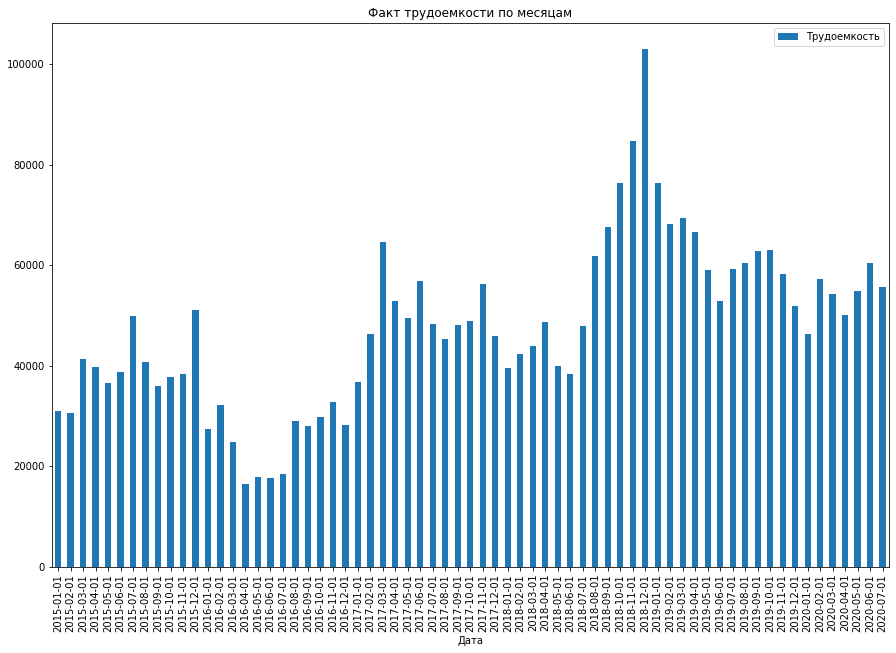

In [112]:
(df
 .groupby(['Дата'])
 .agg({'Трудоемкость': 'sum'})
 .plot(kind='bar', rot=90, figsize=(15,10), title = 'Факт трудоемкости по месяцам')
)

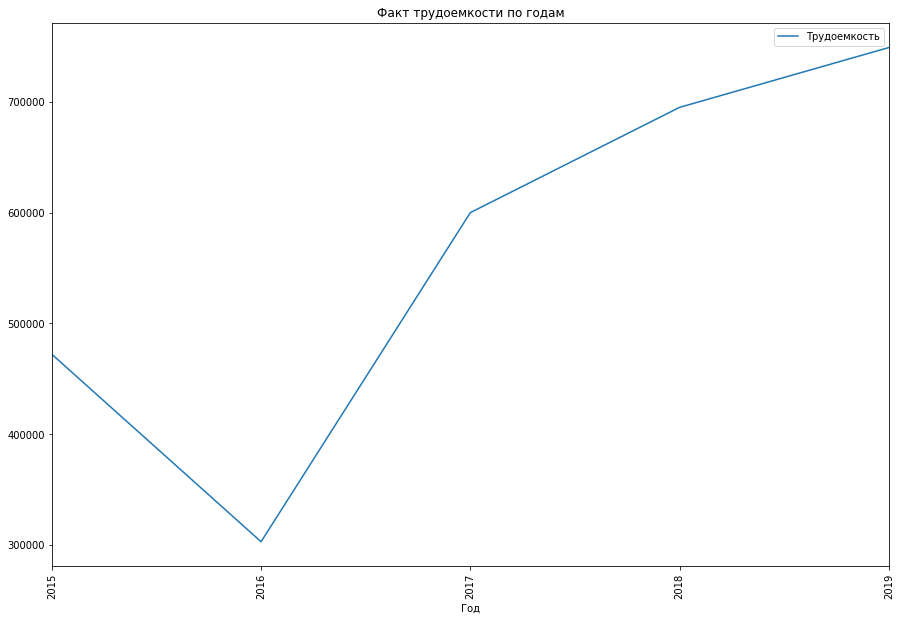

In [113]:
df['Год'] = df['Год'].astype('int')
ax = (df[df['Год'] < 2020]
 .groupby(['Год'])
 .agg({'Трудоемкость': 'sum'})
 .plot(rot=90, figsize=(15,10), title = 'Факт трудоемкости по годам')
)
ax.set_xticks(df[df['Год'] < 2020]['Год'].unique())

Если укрупнить график и проследить развитие только по годам, то видно, что после абсолютно провального 2016 года наблюдается уверенный рост по закрытой трудоемкости. 2020-й год из графика убран, поскольку данные по нему есть только до июля включительно. Если их оставить, картина будет искажена.

Еще можно посмотреть на самые продуктивные месяцы.

In [114]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
          'August', 'September', 'October', 'November', 'December']

In [115]:
df['Месяц'] = pd.Categorical(df['Месяц'], categories=months, ordered=True)

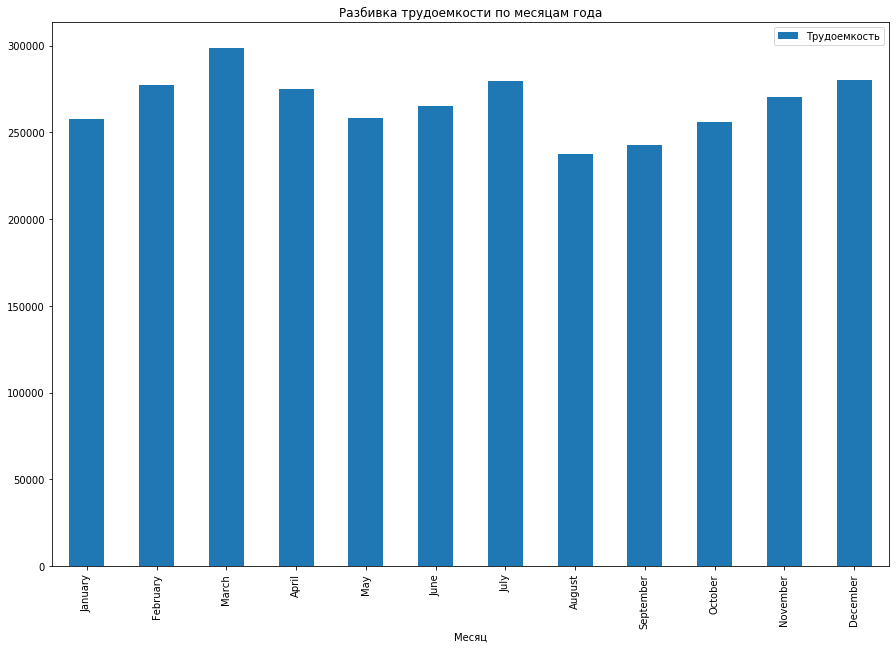

In [116]:
(df
 .groupby(['Месяц'])
 .agg({'Трудоемкость': 'sum'})
 .plot(kind='bar', rot=90, figsize=(15,10), title = 'Разбивка трудоемкости по месяцам года')
)

В абсолютном выражении самыми продуктивными месяцами выглядят март и июль. В августе продуктивность достаточно сильно падает и потом последовательно растет к декабрю. У этой тенденции есть объяснение, не требующее дополнительных данных: разумеется, у предприятия есть заранее сверстанный годовой план по трудоемкости, который нужно выполнить, поэтому к концу года наверстывается все, что не доработано в предыдущие месяцы. 

На начало года тоже нужно обратить отдельное внимание. Дело в том, что в январе и феврале меньше рабочих дней. И если новогодние каникулы не затрагивают техпроцессы, коотрые нельзя останавливать, то февраль в принципе самый короткий месяц, а трудоемкость в нем закрывается на самом топовом уровне. Более подробно изучим ниже, для этого нам понадобится добавить в таблицу такой показатель, как фонд рабочего времени.

Посмотрим на среднюю производительность по месяцам в отличие от суммарной.

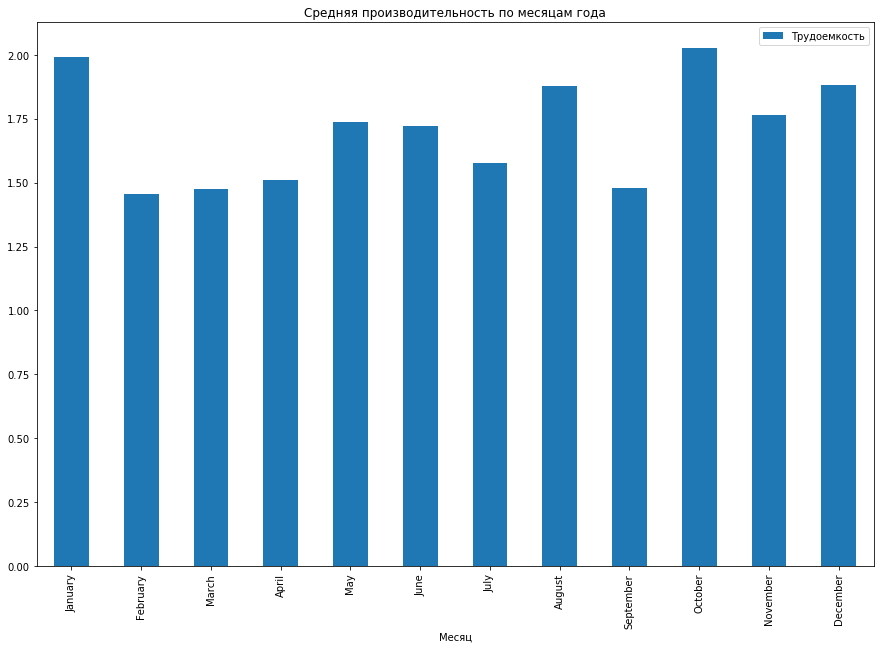

In [117]:
(df
 .groupby(['Месяц'])
 .agg({'Трудоемкость': 'mean'})
 .plot(kind='bar', rot=90, figsize=(15,10), title = 'Средняя производительность по месяцам года')
)

Здесь в лидерах январь и октябрь. Август и декабрь рядом. Таким образом, новогодняя пора - время наибольшей продуктивности завода. Наводит на мысли о вынужденных авралах, чтобы уложиться в сроки. 

In [118]:
month_stack = pd.pivot_table(df, values='Трудоемкость', index=['Дата', 'Цех'], aggfunc='sum')
month_stack

Трудоемкость
Дата       Цех              
2015-01-01 10      2242.0020
           15     13350.3770
           16      2282.0550
           23      5424.2090
           40      7794.1190
...                      ...
2020-07-01 15      8941.2770
           16       639.9580
           23      5783.1626
           40     11487.9620
           251    14443.8750

[455 rows x 1 columns]

In [119]:
pivot_df = pd.pivot_table(df, index='Дата', columns='Цех', values='Трудоемкость', aggfunc='sum').fillna(0)
pivot_df

Цех,4,10,11,15,16,23,40,251
Дата,,,,,,,,
2015-01-01,0.0000,2242.0020,0.0000,13350.3770,2282.0550,5424.2090,7794.1190,0.000
2015-02-01,0.0000,3675.3880,0.0000,9415.6720,2907.5570,6721.4230,7935.8970,0.000
2015-03-01,0.0000,3620.7780,0.0000,15876.4795,3692.4260,9034.3440,9046.1900,0.000
2015-04-01,0.0000,4005.4410,0.0000,13676.6300,2265.9040,8214.1320,11625.1820,0.000
2015-05-01,0.0000,3049.5860,0.0000,14184.0260,1691.1906,9807.0020,7911.9190,0.000
...,...,...,...,...,...,...,...,...
2020-03-01,4312.8735,7634.7862,639.0730,7933.8070,925.1080,7445.5828,9461.7281,15996.300
2020-04-01,3777.0310,5635.7697,2046.2844,8881.2830,644.6436,5583.4315,7806.9010,15721.087
2020-05-01,3673.5601,6219.2750,2072.8980,10528.3000,445.0720,4553.9762,13417.1111,14050.108


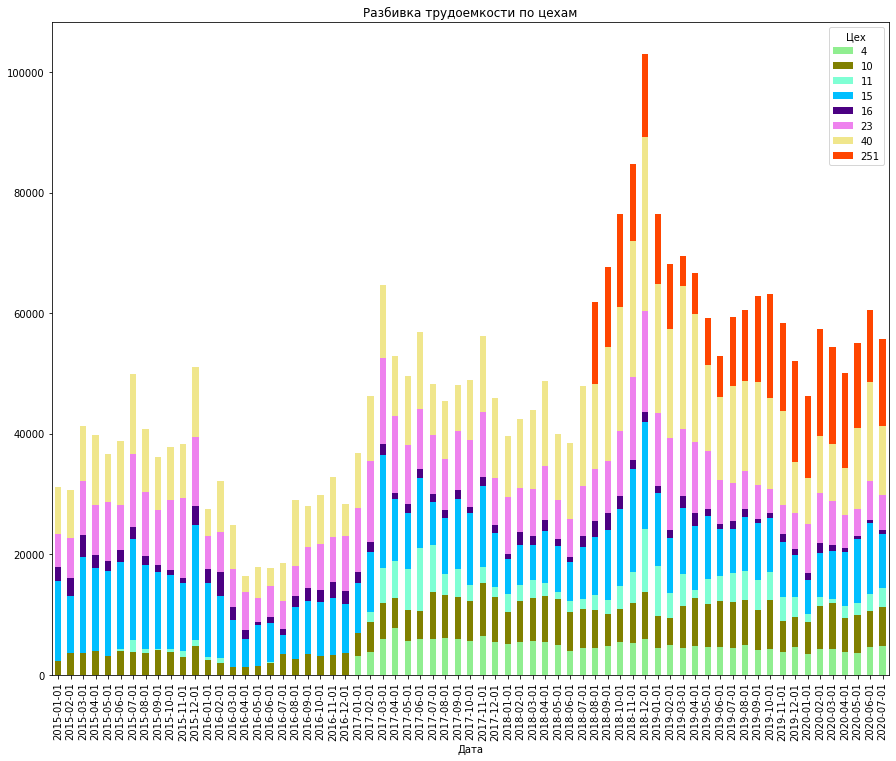

In [120]:
colors = ["#90EE90", "#808000","#7FFFD4", '#00BFFF', '#4B0082', '#EE82EE', '#F0E68C', '#FF4500']
(pivot_df
 .loc[:,[4, 10, 11, 15, 16, 23, 40, 251]]
 .plot
 .bar(stacked=True, color=colors, figsize=(15,12), title = 'Разбивка трудоемкости по цехам')
)

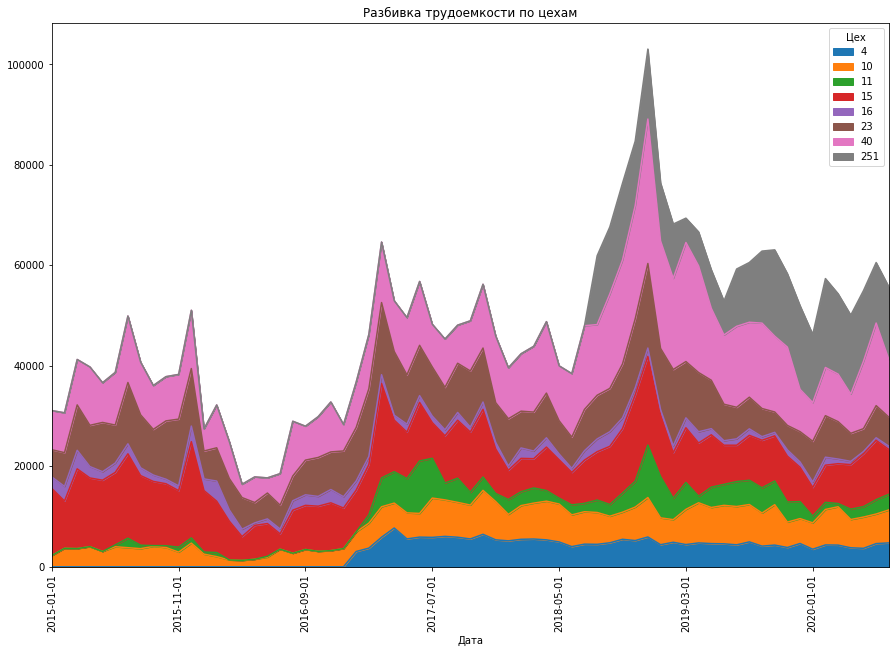

In [121]:
ax = (pivot_df
      .loc[:,[4, 10, 11, 15, 16, 23, 40, 251]]
      .plot
      .area(rot=90, figsize=(15,10), title = 'Разбивка трудоемкости по цехам')
     )

Хорошо видно, как мало вырабатывал цех 11 в течение более чем двух лет. Также видно, что цех 4 появился в разбивке лишь в начале 2017 года, а площадка цеха 251 вошла в состав предприятия в августе 2018 года.

In [122]:
data_perc = pivot_df.divide(pivot_df.sum(axis=1), axis=0)

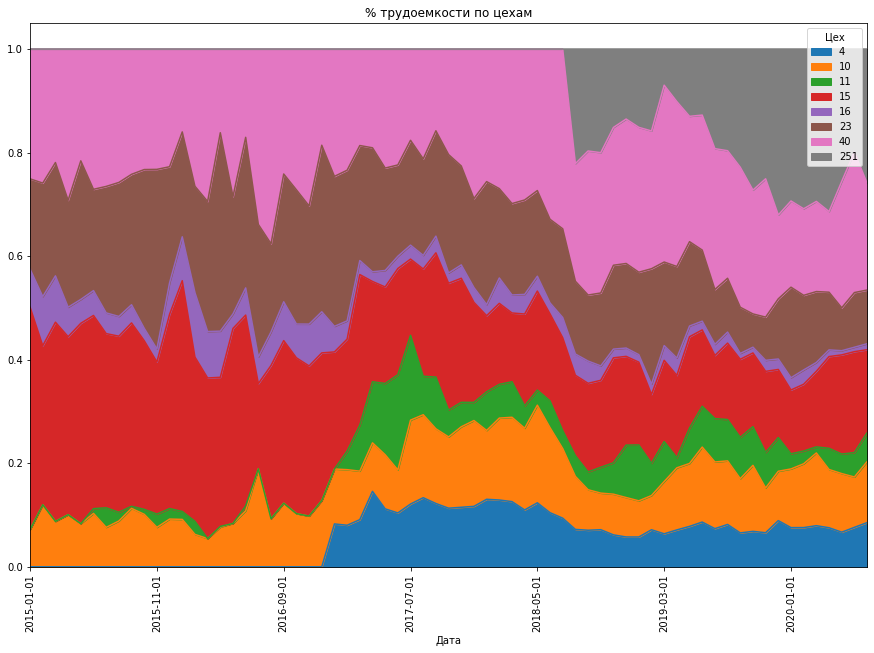

In [123]:
ax = (data_perc
      .loc[:,[4, 10, 11, 15, 16, 23, 40, 251]]
      .plot
      .area(rot=90, figsize=(15,10), title = '% трудоемкости по цехам')
     )

В таком представлении видно, как постепенно снижается доля цеха 15 в общем факте трудоемкости. Также заметно снизилась доля цеха 23, причем это произошло параллельно с загрузкой цеха 4 и особенно цеха 11. Косвенно это может подтверждать, что 4 и особенно 11 цеха разгрузили цех 23. Также отметим, что со временем существенно снизилась доля цеха 16 (штамповка днищ), однако в абсолютных значениях объем выполняемых работ снизился не настолько. Это коррелирует с общей тенденцией к росту закрываемого объема нормочасов в целом по заводу.

Теперь посмотрим на группы производимой продукции. Они находятся в столбце "Код категории". Оснастку, ремонты и днища покажем без разбивки по коду категории, поскольку это исказит картину.

In [124]:
df[df['Шифр'] == 20]['Код категории'].sort_values().unique()

array([ 1,  2,  5,  6, 10, 13, 15, 20, 22, 23, 25, 27, 28, 29, 30, 31, 32,
       33, 34, 36, 37, 38, 40, 44, 45, 48, 49, 52, 54, 55, 56, 58, 59, 62,
       63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 76, 94, 96, 97, 98],
      dtype=int64)

- Все номера меньше 10 и номер 48 в случае с барботером - это изделия для атомной промышленности, назовем категорию "Атомка"
- 10 - это шаровые резервуары
- 13 и 59 - контейнера-цистерны
- 15 - сепараторы
- 20, 22, 25, 27, 28, 29, 68, 69 - емкости
- 23, 29, 36, 48, 49, 54, 94, 97 - это днища, им уже присвоен единый номер 2090000
- 30, 31, 32, 33, 37, 38, 40, 44, 45 - выведенный из оборота ассортимент, выпуск этих изделий прекращен
- 52, 65 - реакторы
- 55 - колонны
- 56 - рамы
- 58 - металлоконструкции
- 62 - теплообменники
- 63 - ресиверы
- 64 - днища, нужно добавить к списку днищ
- 66 - реторты
- 67 - конденсаторы
- 70, 71, 74, 76, 98 - механические работы
- 96 - сложное блочное оборудование, которое нельзя классифицировать в другие категории

In [125]:
atoms = [1,  2,  5,  6]
containers = [13, 59]
volumes = [20, 22, 25, 27, 28, 29, 68, 69]
non_producing = [16, 30, 31, 32, 33, 34, 37, 38, 40, 44, 45]
reactors = [52, 65]
mechanic_works = [70, 71, 74, 76, 98]

In [126]:
df['Номер заказа'] = df.apply(right_numbers, axis = 1)
df.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории,Год_месяц,Месяц,Год,Номер заказа
0,2015-01-01,15,2066633,18,РАЗМЕТЧИК,0.12,20,66,January 2015,January,2015,2066633
1,2015-01-01,15,2066633,19,РАЗМЕТЧИК,0.12,20,66,January 2015,January,2015,2066633
2,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.06,12,15,January 2015,January,2015,1200000
3,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.08,12,63,January 2015,January,2015,1200000
4,2015-01-01,15,205506404,1,РАЗМЕТЧИК,0.02,20,55,January 2015,January,2015,205506404


In [127]:
# Эта функция присваивает кодам категорий их наименования
def categories(row):
    if row['Номер заказа'] == 1200000:
        row['Код категории'] = 'Оснастка'
    elif row['Номер заказа'] == 3000000:
        row['Код категории'] = 'Ремонты'
    elif row['Шифр'] == 20:
        if row['Код категории'] in bottoms and row['Заказ'] not in barboter:
            row['Код категории'] = 'Днища'
        elif row['Код категории'] in atoms or row['Заказ'] in barboter:
            row['Код категории'] = 'Атомка'
        elif row['Код категории'] in containers:
            row['Код категории'] = 'КЦ'
        elif row['Код категории'] in volumes:
            row['Код категории'] = 'Емкости'
        elif row['Код категории'] in non_producing:
            row['Код категории'] = 'Архив'
        elif row['Код категории'] in reactors:
            row['Код категории'] = 'Реакторы'
        elif row['Код категории'] in mechanic_works:
            row['Код категории'] = 'Мехобработка'
        elif row['Код категории'] == 10:
            row['Код категории'] = 'Шаровые резервуары'
        elif row['Код категории'] == 15:
            row['Код категории'] = 'Сепараторы'
        elif row['Код категории'] == 55:
            row['Код категории'] = 'Колонны'
        elif row['Код категории'] == 56:
            row['Код категории'] = 'Рамы'
        elif row['Код категории'] == 58:
            row['Код категории'] = 'Металлоконструкции'
        elif row['Код категории'] == 62:
            row['Код категории'] = 'Теплообменники'
        elif row['Код категории'] == 63:
            row['Код категории'] = 'Ресиверы'
        elif row['Код категории'] == 66:
            row['Код категории'] = 'Реторты'
        elif row['Код категории'] == 67:
            row['Код категории'] = 'Конденсаторы'
        elif row['Код категории'] == 96:
            row['Код категории'] = 'Блоки'
    return row['Код категории']

In [128]:
df['Категория'] = df.apply(categories, axis = 1)

In [129]:
df.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код категории,Год_месяц,Месяц,Год,Номер заказа,Категория
0,2015-01-01,15,2066633,18,РАЗМЕТЧИК,0.12,20,66,January 2015,January,2015,2066633,Реторты
1,2015-01-01,15,2066633,19,РАЗМЕТЧИК,0.12,20,66,January 2015,January,2015,2066633,Реторты
2,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.06,12,15,January 2015,January,2015,1200000,Оснастка
3,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.08,12,63,January 2015,January,2015,1200000,Оснастка
4,2015-01-01,15,205506404,1,РАЗМЕТЧИК,0.02,20,55,January 2015,January,2015,205506404,Колонны


In [130]:
df = df[['Дата', 'Цех', 'Номер заказа', 'К-т', 'Профессия', 'Трудоемкость', 'Шифр', 'Код категории', 'Год_месяц', \
         'Месяц', 'Год', 'Категория']]
df.head()

,Дата,Цех,Номер заказа,К-т,Профессия,Трудоемкость,Шифр,Код категории,Год_месяц,Месяц,Год,Категория
0,2015-01-01,15,2066633,18,РАЗМЕТЧИК,0.12,20,66,January 2015,January,2015,Реторты
1,2015-01-01,15,2066633,19,РАЗМЕТЧИК,0.12,20,66,January 2015,January,2015,Реторты
2,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.06,12,15,January 2015,January,2015,Оснастка
3,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.08,12,63,January 2015,January,2015,Оснастка
4,2015-01-01,15,205506404,1,РАЗМЕТЧИК,0.02,20,55,January 2015,January,2015,Колонны


In [131]:
df['Категория'].unique()

array(['Реторты', 'Оснастка', 'Колонны', 'Рамы', 'Сепараторы', 'Ресиверы',
       'Архив', 'Мехобработка', 'Днища', 'Реакторы', 'Емкости', 'Ремонты',
       'Шаровые резервуары', 'Конденсаторы', 'Теплообменники', 'Атомка',
       'КЦ', 'Блоки', 'Металлоконструкции'], dtype=object)

Text(0.5, 0.98, 'Распределение усилий по категориям')

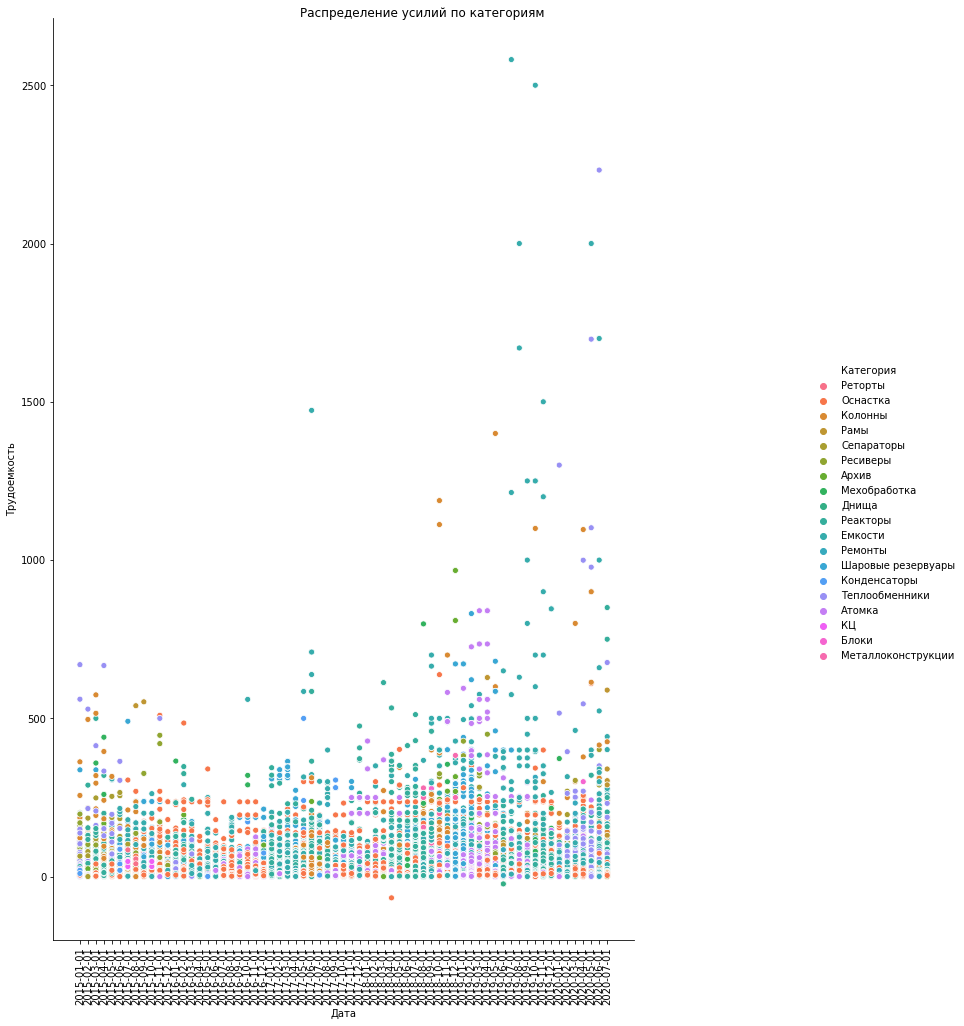

In [132]:
g = sns.relplot(data = df
            ,y = 'Трудоемкость'
            ,x = 'Дата'
            ,hue = 'Категория'
            )
g.fig.set_size_inches(15,15)
g.set_xticklabels(rotation=90)
g.fig.suptitle("Распределение усилий по категориям")

График не самый информативный, но на нем видно, какие категории собирают наибольшее, скажем так, внимание и концентрацию усилий. Так, в 2020 году реакторы, колонны и теплообменники могли собирать на себе под 2500 фактически отработанных нормочасов. Кроме того, видна тенденция к увеличению этой суммы с 500-700 до 2000-2500 со временем. Это может свидетельствовать об уменьшении ежемесячного пула заказов, находящихся одновременно в производстве, что позволяет сосредоточить большие усилия на крупных проектах. Однако нельзя забывать и об общем росте закрытой фактической трудоемкости с течением времени.

Text(0.5, 0.98, 'Присутствие категорий в месячной номенклатуре')

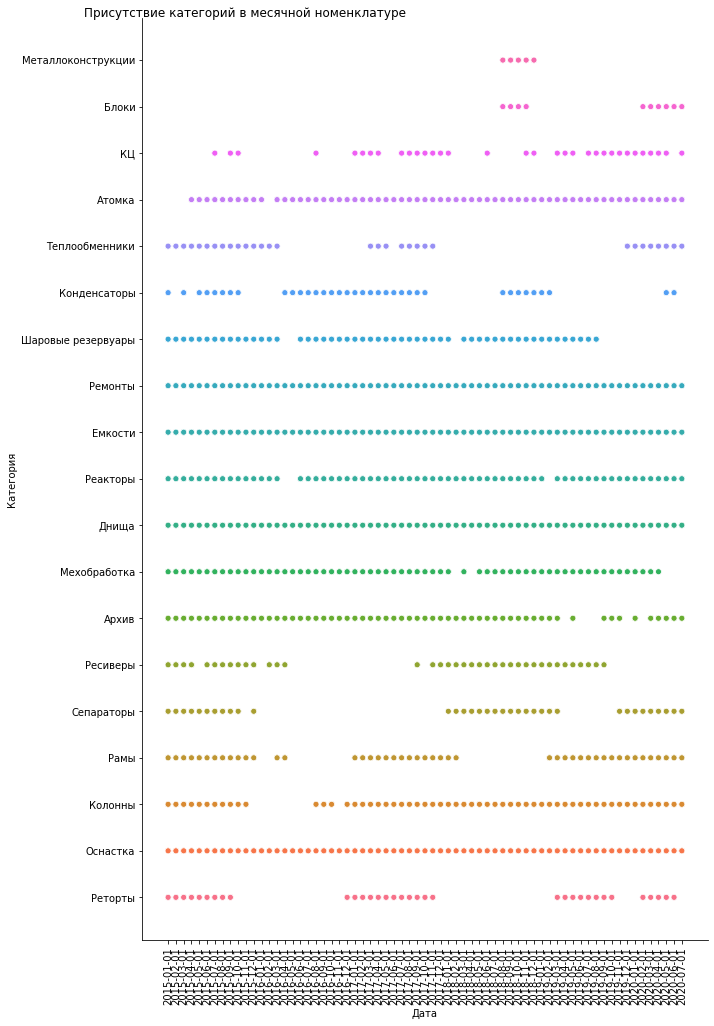

In [133]:
g = sns.relplot(data = df
            ,y = 'Категория'
            ,x = 'Дата'
            ,hue = 'Категория'
            ,legend=False
            )
g.fig.set_size_inches(15,15)
g.set_xticklabels(rotation=90)
g.fig.suptitle("Присутствие категорий в месячной номенклатуре")

- Понятно, что ремонты, оснастка и днища никогда не выпадали из номенклатуры. 
- А вот из основной продукции подобным достижением может похвастать только категория "Емкости". 
- Реакторы и заказы на мехобработку конструкций если и покидают пул заводских заказов, то ненадолго. 
- Заказы для атомной промышленности появились в ассортименте в начале 2015 года и с тех пор только на один месяц пропадали из номенклатуры. 
- Металлоконструкции отдельными заказами были в номенклатуре в конце 2018 года. Это ассортимент новой для завода площадки, то есть цеха 251. После вхождения в состав завода площадка закончила работы по металлоконструкциям, запущенным в производство до присоединения, и больше в фактически отработанных нормочасах эта номенклатура не значилась.
- Категория "Блоки" охватывает сложное блочное оборудование, которое нельзя отнести ни к какой другой категории (поскольку в них тоже бывают как блочные заказы, так и отдельные изделия). Такие заказы появлялись в производстве лишь дважды, второй из этих случаев на момент этого проекта был запланирован к отгрузке на конец 2020 года.
- Контейнера-цистерны были в интенсивном производстве в период 2012-2013 годов и были изготовлены с большим запасом, поэтому до конца 2019 года закрытая по ним трудоемкость относится не к изготовлению изделий, а работам по их расконсервации и подготовке к отгрузке. А вот в июле 2019 года в работу по изготовлению поступил новый большой заказ на 400 контейнеров, а в 2020 еще один, не менее объемный.
- Теплообменники нельзя отнести к постоянной номенклатуре завода; кроме того, до 2017 года включительно изготавливались сравнительно небольшие изделия этого типа; тогда как в конце 2019 года завод приступил к изготовлению аппаратов гораздо большего объема и сложности.
- С конденсаторами, ресиверами, рамами и сепараторами та же история: завод обладает документацией на изготовление аппаратов такого типа, но, очевидно, это не самая востребованная у заказчиков категория. 
- А вот шаровые резервуары - одно из основных направлений деятельности завода. Емкости такого типа завод может изготавливать самых разных объемов и комплектации, в том числе с последующими шеф-монтажными работами на производственной площадке заказчика. Возникшая в 2020 пауза в производстве ШР связана с тем, что на завод поступил новый, сложный заказ, старт работ по которому откладывается в связи с уточнением техдокументации и длительным процессом материально-технического снабжения.
- Колонны - также одна из постояннодействующих категорий. Их не было в производстве только в 2016 году, в период самого крупного падения объемов выполненных работ за последние годы.
- Реторты, как правило, заказываются наборами по несколько комплектов. Трудоемкость их изготовления не слишком велика, поэтому они появляются в производстве циклически: отгрузив 5-6 компектов, на следующие примерно полгода-год завод свободен от реторт.

Можно посмотреть, какое количество уникальных заказов было в производстве каждый месяц. Учтем, что все днища, ремонты и оснастка сведены в один заказ для каждой категории; остальные заказы считаем без разбивки по комплектам.

In [134]:
df['Дата формат'] = pd.to_datetime(df['Дата'])
df.head()

,Дата,Цех,Номер заказа,К-т,Профессия,Трудоемкость,Шифр,Код категории,Год_месяц,Месяц,Год,Категория,Дата формат
0,2015-01-01,15,2066633,18,РАЗМЕТЧИК,0.12,20,66,January 2015,January,2015,Реторты,2015-01-01
1,2015-01-01,15,2066633,19,РАЗМЕТЧИК,0.12,20,66,January 2015,January,2015,Реторты,2015-01-01
2,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.06,12,15,January 2015,January,2015,Оснастка,2015-01-01
3,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.08,12,63,January 2015,January,2015,Оснастка,2015-01-01
4,2015-01-01,15,205506404,1,РАЗМЕТЧИК,0.02,20,55,January 2015,January,2015,Колонны,2015-01-01


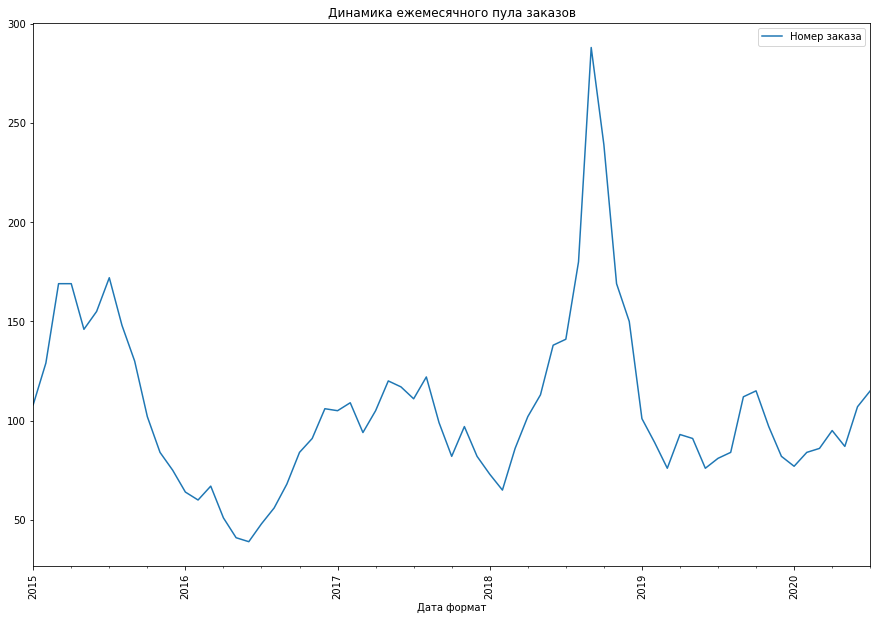

In [135]:
ax = (df
 .groupby(['Дата формат'])
 .agg({'Номер заказа': lambda x: x.nunique()})
 .plot(rot=90, figsize=(15,10), title = 'Динамика ежемесячного пула заказов')
)
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
#plt.gcf().autofmt_xdate()
#ax.set_xticklabels(df['Дата формат'], rotation=90)
plt.show()

Интересно, что этот график почти полностью повторяет график, иллюстрирующий объемы закрытой трудоемкости по месяцам в нормочасах. Чем больше отработано нормочасов, тем шире пул одновременно находящихся в производстве заказов, и наоборот. Пик пришелся на конец 2019 года, а меньше всего заказов одновременно находилось в производстве в середине 2016 года, в самый кризисный период.

Однако у этой медали есть другая сторона. Дело в том, что основные заказы в производстве носят номера вида XX-YY-ZZZ, где XX - тип заказа (12 - оснастка, 30 - ремонты, 20 - товарный заказ), YY - категория (подробно разбирались выше), а ZZZ - порядковый номер. При этом в связи с производственной необходимостью широко практикуется разбиение основного товарного заказа на так называемые нетоварные точки, которые нумеруются следующим образом: XX-YY-ZZZ-PP, где PP - номер точки. Так, например, шаровый резервуар 2010653 может состоять из следующих точек: 201065301 - элементы корпуса, 201065302 - обечайки, 201065303 - внутренняя лестница и так далее. А на графике выше показаны все уникальные номера заказов - и товарные, и нетоварные точки. Углубимся в ситуацию и укрупним разбивку до исключительно товарных заказов.

In [136]:
df.columns = ['Дата', 'Цех', 'Заказ', 'К-т', 'Профессия', 'Трудоемкость', 'Шифр', 'Код', 'Год_месяц', \
              'Месяц', 'Год', 'Категория', 'Дата_м']
df.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код,Год_месяц,Месяц,Год,Категория,Дата_м
0,2015-01-01,15,2066633,18,РАЗМЕТЧИК,0.12,20,66,January 2015,January,2015,Реторты,2015-01-01
1,2015-01-01,15,2066633,19,РАЗМЕТЧИК,0.12,20,66,January 2015,January,2015,Реторты,2015-01-01
2,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.06,12,15,January 2015,January,2015,Оснастка,2015-01-01
3,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.08,12,63,January 2015,January,2015,Оснастка,2015-01-01
4,2015-01-01,15,205506404,1,РАЗМЕТЧИК,0.02,20,55,January 2015,January,2015,Колонны,2015-01-01


In [137]:
def product_number(i):
    if i > 10000000:
        product = i // 100
    else:
        product = i
    return product

In [138]:
df['Товар'] = df['Заказ'].apply(product_number)
df.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код,Год_месяц,Месяц,Год,Категория,Дата_м,Товар
0,2015-01-01,15,2066633,18,РАЗМЕТЧИК,0.12,20,66,January 2015,January,2015,Реторты,2015-01-01,2066633
1,2015-01-01,15,2066633,19,РАЗМЕТЧИК,0.12,20,66,January 2015,January,2015,Реторты,2015-01-01,2066633
2,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.06,12,15,January 2015,January,2015,Оснастка,2015-01-01,1200000
3,2015-01-01,15,1200000,1,РАЗМЕТЧИК,0.08,12,63,January 2015,January,2015,Оснастка,2015-01-01,1200000
4,2015-01-01,15,205506404,1,РАЗМЕТЧИК,0.02,20,55,January 2015,January,2015,Колонны,2015-01-01,2055064


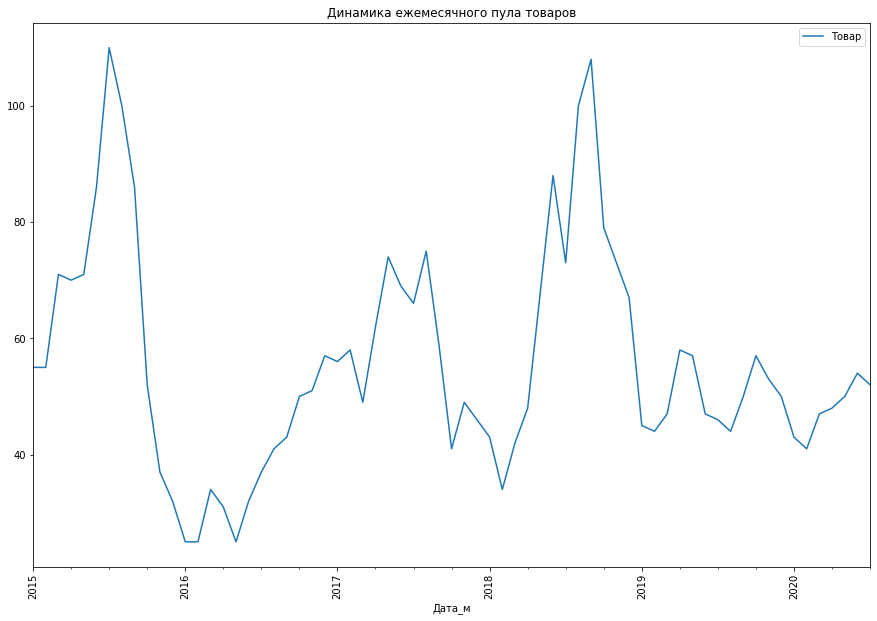

In [139]:
ax = (df
 .groupby(['Дата_м'])
 .agg({'Товар': lambda x: x.nunique()})
 .plot(rot=90, figsize=(15,10), title = 'Динамика ежемесячного пула товаров')
)
#plt.gcf().autofmt_xdate()
#ax.set_xticklabels(df['Дата формат'], rotation=90)
plt.show()

Совсем другая картина. Антирекорды 2016 года никуда не делись - зато теперь видно, как много точек пришлось выделить из основных товарных заказов в конце 2018 года, при том что собственно товаров в производстве было не больше, чем в середине 2015 года. Этот график уже совсем не похож на график объема отработанных нормочасов, хотя пик в конце 2018 года, по-видимому, будет украшать все графики, построенные по этим данным. Но сопоставляя два этих графика, можно увидеть, что хоть в середине 2015 года одновременно в производстве было наибольшее число товарных заказов, все они были малотрудоемкие. Заказы конца 2018 года требовали несоизмеримо больших трудозатрат; и хотя в этом проекте мы не анализируем экономическую эффективность производства, поскольку данных для такого анализа нет - тем не менее можно предположить, что чем заказ объемнее, тем дороже он стоит и тем больше дохода приносит предприятию.

In [140]:
products = df.query('Товар > 2000000 and Товар < 3000000')

Text(0.5, 0.98, 'Сроки изготовления заказов по категориям')

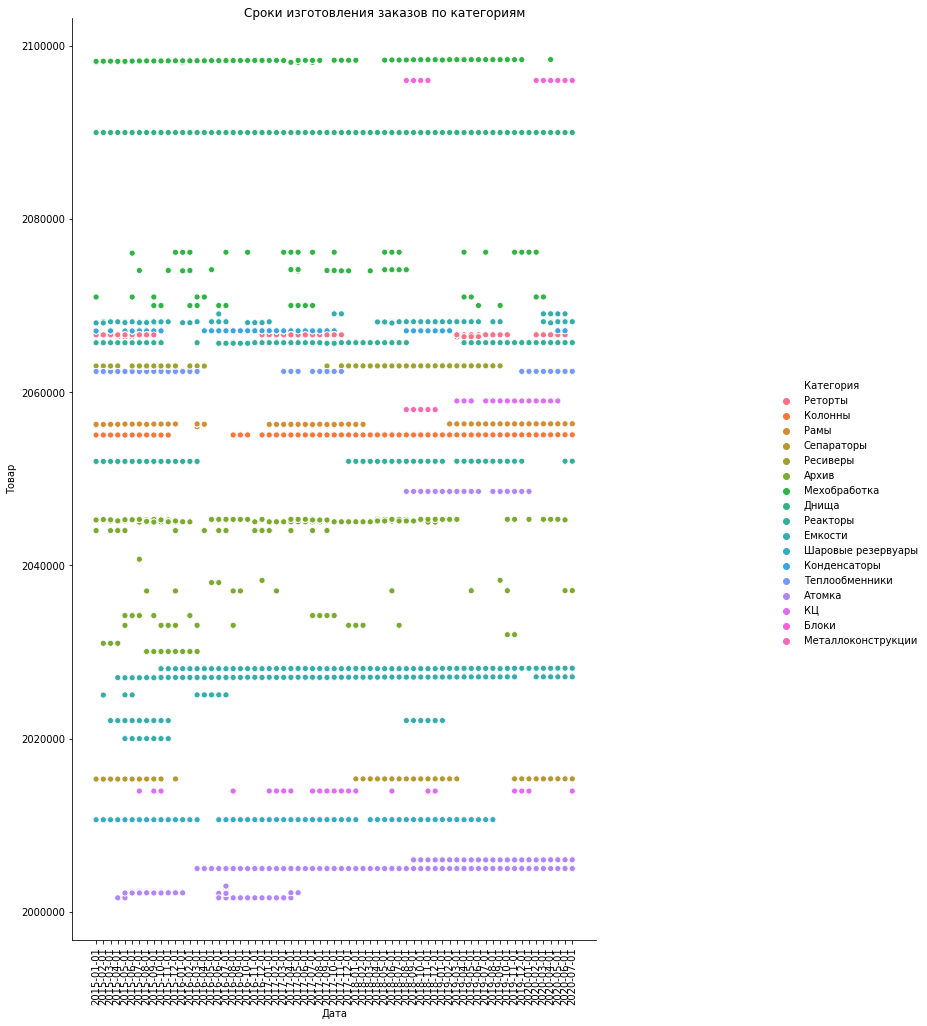

In [141]:
g = sns.relplot(data = products
            ,y = 'Товар'
            ,x = 'Дата'
            ,hue = 'Категория'
            )
g.fig.set_size_inches(15,15)
g.set_xticklabels(rotation=90)
g.fig.suptitle("Сроки изготовления заказов по категориям")

Теперь видно, как долго находятся в производстве конкретные заказы по категориям. Отдельно можно показать заказы в каждой из категорий, но в данном проекте это не требуется. Для примера посмотрим на реакторы.

Text(0.5, 0.98, 'Сроки изготовления реакторов')

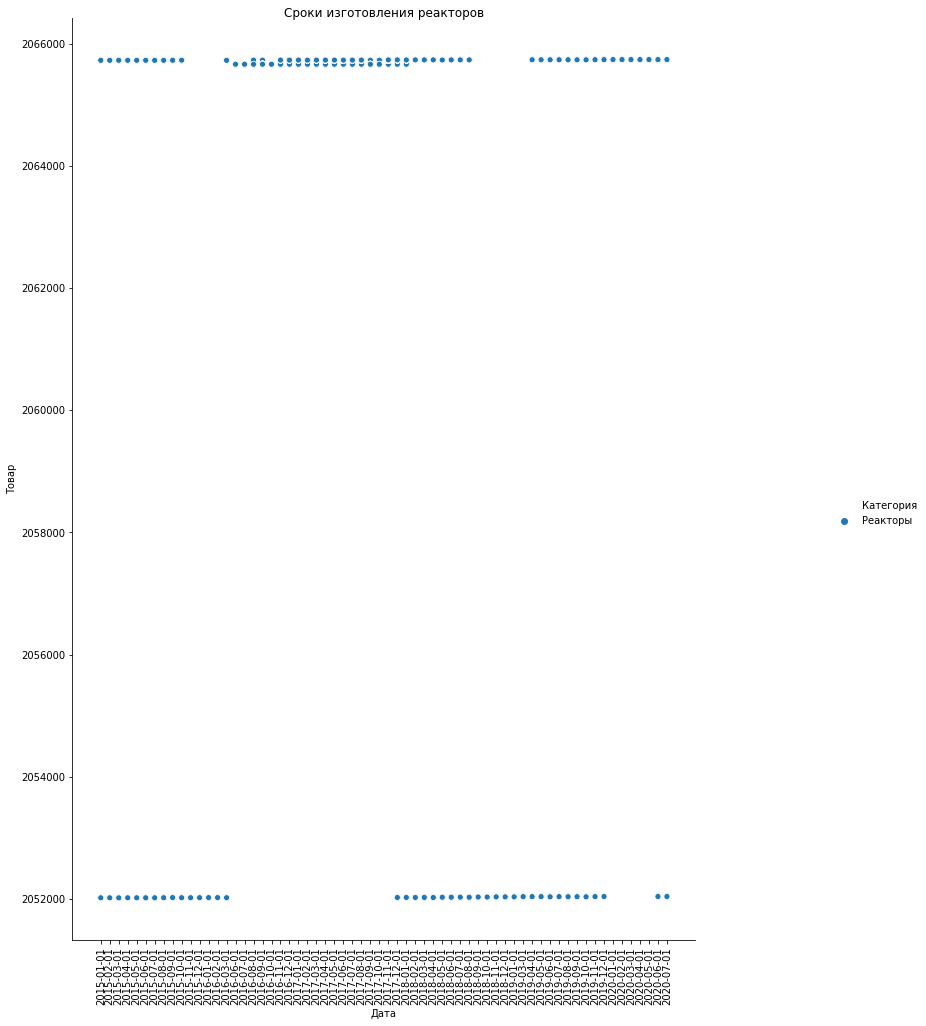

In [142]:
g = sns.relplot(data = products[products['Категория'] == 'Реакторы']
            ,y = 'Товар'
            ,x = 'Дата'
            ,hue = 'Категория'
            )
g.fig.set_size_inches(15,15)
g.set_xticklabels(rotation=90)
g.fig.suptitle("Сроки изготовления реакторов")

Не очень понятно. Попробуем приблизиться к реакторам, чьи номера находятся близко к значению 2052000

In [143]:
reactors_2052 = products[products['Категория'] == 'Реакторы'].reset_index()
reactors_2052 = reactors_2052[reactors_2052['Товар'] < 2054000].reset_index()
reactors_2052 = reactors_2052[['Дата', 'Цех', 'Заказ', 'К-т', 'Профессия', 'Трудоемкость', 'Шифр', 'Код', 'Год_месяц', \
              'Месяц', 'Год', 'Категория', 'Дата_м', 'Товар']]
reactors_2052.head()

,Дата,Цех,Заказ,К-т,Профессия,Трудоемкость,Шифр,Код,Год_месяц,Месяц,Год,Категория,Дата_м,Товар
0,2015-01-01,15,205201961,1,СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ,0.08,20,52,January 2015,January,2015,Реакторы,2015-01-01,2052019
1,2015-01-01,15,205201961,1,СТРОГАЛЬЩИК,0.96,20,52,January 2015,January,2015,Реакторы,2015-01-01,2052019
2,2015-01-01,15,205201961,1,СТРОГАЛЬЩИК,0.50,20,52,January 2015,January,2015,Реакторы,2015-01-01,2052019
3,2015-01-01,15,205201961,1,СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ,0.08,20,52,January 2015,January,2015,Реакторы,2015-01-01,2052019
4,2015-01-01,15,205201911,1,СЛЕСАРЬ МЕХАНОСБОРОЧНЫХ РАБОТ,0.16,20,52,January 2015,January,2015,Реакторы,2015-01-01,2052019


Text(0.5, 0.98, 'Сроки изготовления реакторов 2052XXX')

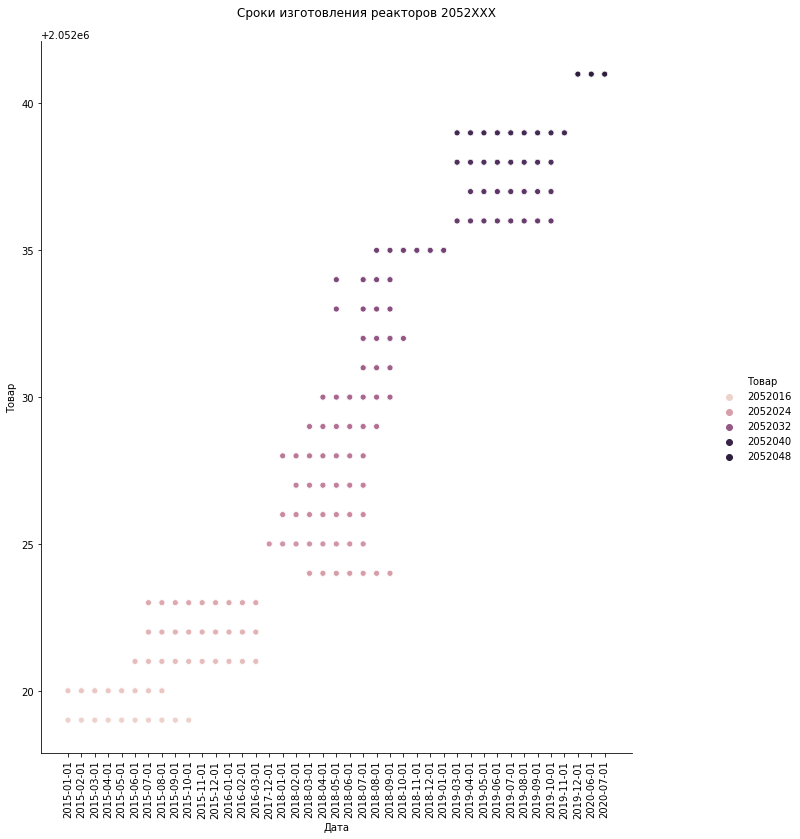

In [144]:
g = sns.relplot(data = reactors_2052
            ,y = 'Товар'
            ,x = 'Дата'
            ,hue = 'Товар'
            )
g.fig.set_size_inches(12,12)
g.set_xticklabels(rotation=90)
g.fig.suptitle("Сроки изготовления реакторов 2052XXX")

Вот так - от шести до восьми месяцев на заводе занимает изготовление одного реактора. Напомним, в рамках рассматриваемых данных показаны только работы непосредственно в производственных цехах. Подготовка производства, разработка документации, снабжение - остаются за скобками этого проекта. Таким образом, при планировании изготовления реактора с параметрами, сопоставимыми с параметрами представленных на графике реакторов, нужно закладывать только на изготовление 6-8 месяцев. Это объективная картина, полученная опытным путем.

In [145]:
pivot_category = pd.pivot_table(df, index='Дата', columns='Категория', values='Трудоемкость', aggfunc='sum').fillna(0)
pivot_category

Категория,Архив,Атомка,Блоки,Днища,Емкости,КЦ,Колонны,Конденсаторы,Металлоконструкции,Мехобработка,Оснастка,Рамы,Реакторы,Ремонты,Ресиверы,Реторты,Сепараторы,Теплообменники,Шаровые резервуары
Дата,,,,,,,,,,,,,,,,,,,
2015-01-01,140.878,0.0000,0.0000,5995.1070,12.8900,0.000,4862.1620,73.6200,0.0,330.973,2897.6770,659.2960,1777.5240,395.7840,4386.520,794.3110,3845.8280,2893.2900,2026.902
2015-02-01,334.498,0.0000,0.0000,4817.5090,122.3400,0.000,3149.4730,0.0000,0.0,448.850,2841.2540,565.5110,3843.8100,442.6910,1605.825,741.0290,6202.3270,2233.2540,3307.566
2015-03-01,896.234,0.0000,0.0000,10199.6090,400.1350,0.000,4849.4160,17.4660,0.0,1187.030,2139.7920,1091.7520,7940.9080,64.2680,637.921,1475.9760,4661.2885,2093.7140,3614.708
2015-04-01,2043.364,17.9000,0.0000,6327.9090,1627.6670,0.000,8195.7970,0.0000,0.0,1789.720,1818.8010,849.2170,5872.9640,628.7400,26.542,1338.9210,4147.0090,2661.8170,2440.921
2015-05-01,1110.296,10.3260,0.0000,3028.1320,4181.2710,0.000,6583.4710,15.6000,0.0,126.490,2281.4106,301.4100,4472.9960,673.7750,0.000,1695.8740,5847.0930,1537.9300,4777.649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-01,1.322,9335.1039,7.0060,773.1660,11298.4236,10028.341,3208.8782,0.0000,0.0,13.320,5578.2029,220.1000,1750.4919,1619.2508,0.000,0.1500,3784.6354,6730.8669,0.000
2020-04-01,5.101,6411.9710,945.2780,1560.0810,5347.4135,10568.144,4975.7273,0.0000,0.0,14.200,6667.3481,1440.1830,2288.3705,664.0270,0.000,722.2000,309.1008,8177.2860,0.000
2020-05-01,15.230,7820.0742,393.3416,491.9520,9929.4937,9445.702,3932.6150,132.8476,0.0,0.000,5391.2112,1340.7291,3252.6532,478.1636,0.000,1148.3977,619.0280,10568.8615,0.000


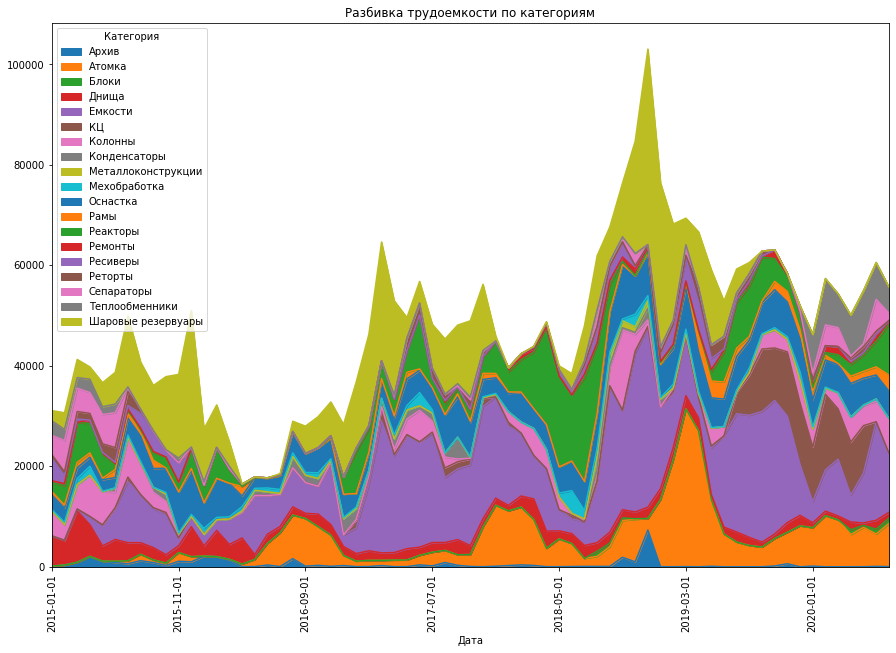

In [146]:
ax = (pivot_category
      .loc[:,['Архив', 'Атомка', 'Блоки', 'Днища', 'Емкости', 'КЦ', 'Колонны', 'Конденсаторы', 'Металлоконструкции',\
              'Мехобработка', 'Оснастка', 'Рамы', 'Реакторы', 'Ремонты', 'Ресиверы', 'Реторты', 'Сепараторы', \
              'Теплообменники', 'Шаровые резервуары']]
      .plot
      .area(rot=90, figsize=(15,10), title = 'Разбивка трудоемкости по категориям')
     )

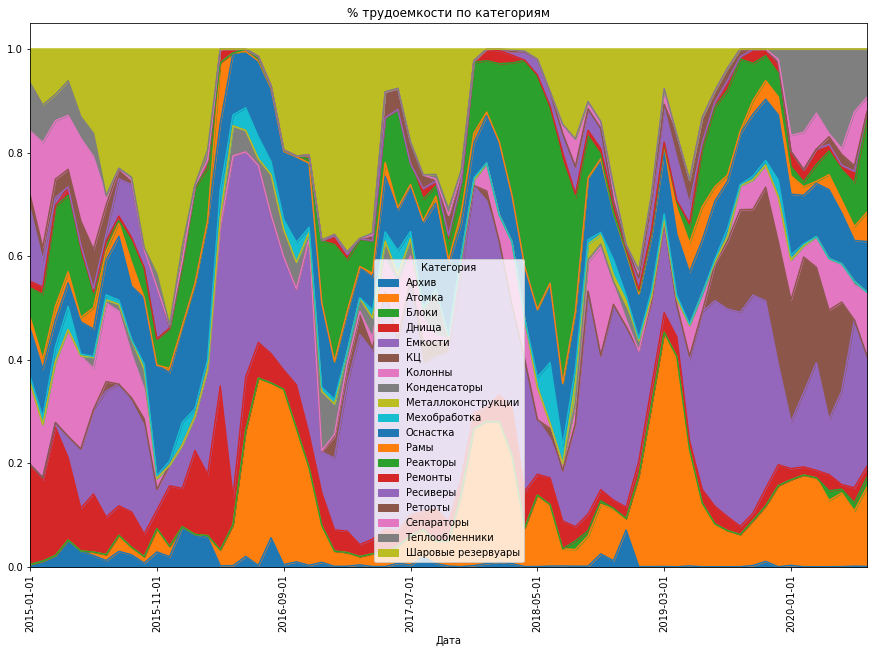

In [147]:
category_perc = pivot_category.divide(pivot_df.sum(axis=1), axis=0)
ax = (category_perc
      .loc[:,['Архив', 'Атомка', 'Блоки', 'Днища', 'Емкости', 'КЦ', 'Колонны', 'Конденсаторы', 'Металлоконструкции',\
              'Мехобработка', 'Оснастка', 'Рамы', 'Реакторы', 'Ремонты', 'Ресиверы', 'Реторты', 'Сепараторы', \
              'Теплообменники', 'Шаровые резервуары']]
      .plot
      .area(rot=90, figsize=(15,10), title = '% трудоемкости по категориям')
     )

Наибольший удельный вес по трудоемкости из ассортимента выпускаемой продукции имеют емкости и шаровые резервуары. Эпизодически в эту когорту попадает также атомная продукция. Отметим, речь идет о ежемесячно закрываемых нормочасах, а не о полной трудоемкости конкретного заказа. Также на стыке 2017-2018 годов "выстрелило" реакторное оборудование, по-настоящему тяжелые заказы.

**Наконец, попробуем проанализировать загрузку завода с точки зрения выработки относительно фонда рабочего времени.** Для этого нам понадобятся:
- списочная численность основных производственных рабочих (ОПР) каждого цеха на каждый месяц из рассматриваемого промежутка времени;
- производственный календарь на каждый год (в нем расписано число рабочих часов на каждый месяц при 40-часовой рабочей неделе);
- коэффициент невыходов (традиционно принимается равным 0.88).

In [148]:
opr = pd.read_excel('uxm_opr.xlsx')
opr.head()

,Дата/Цех,4,11,15,16,23,251,40,40мх,Рабочие часы
0,2017-01-01,20,NaN,91,8,35,NaN,94,22,136
1,2017-02-01,21,19.0,86,7,36,NaN,100,20,143
2,2017-03-01,21,23.0,91,7,36,NaN,103,21,175
3,2017-04-01,22,23.0,88,7,43,NaN,97,20,160
4,2017-05-01,17,30.0,98,7,29,NaN,98,21,160


In [149]:
opr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 10 columns):
Дата/Цех        43 non-null datetime64[ns]
4               43 non-null int64
11              42 non-null float64
15              43 non-null int64
16              43 non-null int64
23              43 non-null int64
251             24 non-null float64
40              43 non-null int64
40мх            43 non-null int64
Рабочие часы    43 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(7)
memory usage: 3.5 KB


Столбцы, в которых есть пропуски, приняли формат float, что нам не подходит. Меняем Nan на нули, приводим столбцы к нужному типу, 40мх меняем на номер 10

In [150]:
opr[[11]] = opr[[11]].fillna(value=0)

In [151]:
opr[[251]] = opr[[251]].fillna(value=0)

In [152]:
opr.columns = ['Дата', 4, 11, 15, 16, 23, 251, 40, 10, 'Рабочие часы']
opr.head()

,Дата,4,11,15,16,23,251,40,10,Рабочие часы
0,2017-01-01,20,0.0,91,8,35,0.0,94,22,136
1,2017-02-01,21,19.0,86,7,36,0.0,100,20,143
2,2017-03-01,21,23.0,91,7,36,0.0,103,21,175
3,2017-04-01,22,23.0,88,7,43,0.0,97,20,160
4,2017-05-01,17,30.0,98,7,29,0.0,98,21,160


In [153]:
opr[11] = opr[11].astype('int64')
opr[251] = opr[251].astype('int64')
opr.head()

,Дата,4,11,15,16,23,251,40,10,Рабочие часы
0,2017-01-01,20,0,91,8,35,0,94,22,136
1,2017-02-01,21,19,86,7,36,0,100,20,143
2,2017-03-01,21,23,91,7,36,0,103,21,175
3,2017-04-01,22,23,88,7,43,0,97,20,160
4,2017-05-01,17,30,98,7,29,0,98,21,160


In [154]:
opr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 10 columns):
Дата            43 non-null datetime64[ns]
4               43 non-null int64
11              43 non-null int64
15              43 non-null int64
16              43 non-null int64
23              43 non-null int64
251             43 non-null int64
40              43 non-null int64
10              43 non-null int64
Рабочие часы    43 non-null int64
dtypes: datetime64[ns](1), int64(9)
memory usage: 3.5 KB


In [155]:
opr_rot = opr.melt(id_vars = ['Дата', 'Рабочие часы'], value_vars = [4, 11, 15, 16, 23, 251, 40, 10])
opr_rot

,Дата,Рабочие часы,variable,value
0,2017-01-01,136,4,20
1,2017-02-01,143,4,21
2,2017-03-01,175,4,21
3,2017-04-01,160,4,22
4,2017-05-01,160,4,17
...,...,...,...,...
339,2020-03-01,168,10,34
340,2020-04-01,175,10,29
341,2020-05-01,135,10,31
342,2020-06-01,167,10,31


In [156]:
opr_rot.columns = ['Дата', 'Рабочие часы', 'Цех', 'ОПР']
opr_rot.head()

,Дата,Рабочие часы,Цех,ОПР
0,2017-01-01,136,4,20
1,2017-02-01,143,4,21
2,2017-03-01,175,4,21
3,2017-04-01,160,4,22
4,2017-05-01,160,4,17


In [157]:
def room_number(i):
    room = 'Цех_' + str(i)
    return room

In [158]:
opr_rot['Номер_цеха'] = opr_rot['Цех'].apply(room_number)
opr_rot.head()

,Дата,Рабочие часы,Цех,ОПР,Номер_цеха
0,2017-01-01,136,4,20,Цех_4
1,2017-02-01,143,4,21,Цех_4
2,2017-03-01,175,4,21,Цех_4
3,2017-04-01,160,4,22,Цех_4
4,2017-05-01,160,4,17,Цех_4


(array([736330., 736511., 736695., 736876., 737060., 737241., 737425.,
        737607.]), <a list of 8 Text xticklabel objects>)

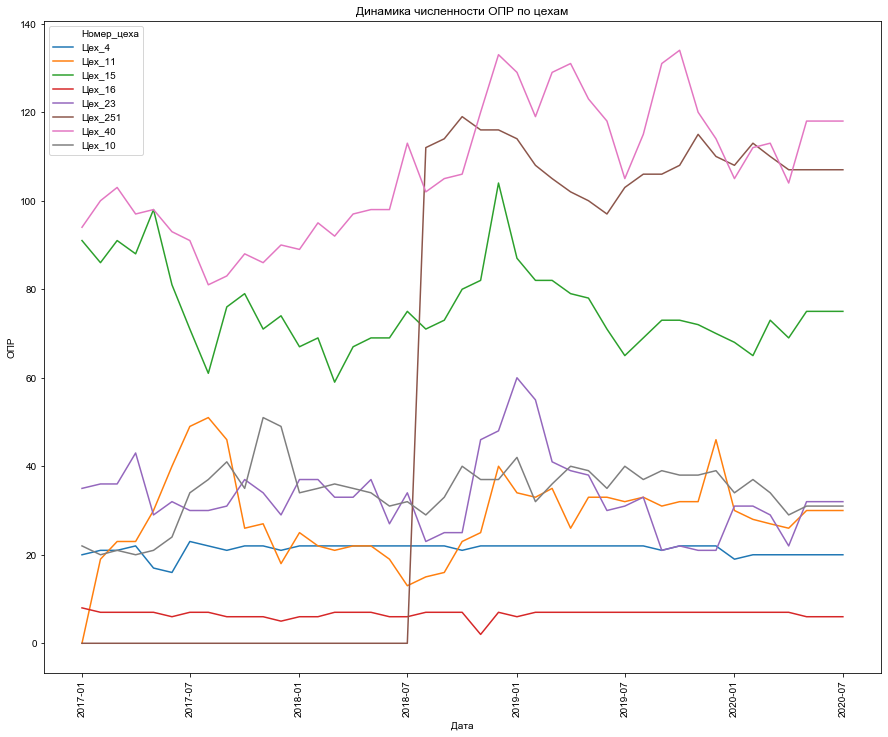

In [159]:
title_rot = 'Динамика численности ОПР по цехам'
plt.figure(figsize=(15, 12))
g = (sns.lineplot(
    x='Дата',
    y='ОПР',
    hue='Номер_цеха',
    data = opr_rot,
    markers=True,
    dashes=False,
    ci = None)
    .set_title(title_rot)
)
sns.set(style="ticks", rc={"lines.linewidth": 7})
plt.xticks(rotation='vertical')

Такую же картину, но в другом масштабе, мы получим, если вместо численности ОПР покажем на графике фонд рабочего времени по цехам и месяцам. Видим, что цех 40 безоговорочный лидер по численности ОПР и ФРВ: даже без учета отдела механообработки он считанные разы уступал лидерство сторонней площадке (цех 251), а цех 15 лишь однажды сравнялся с ним по численности. Цех 23 долгое время опережал цех 11, но начиная со второй половины 2019 года ему уступает. Скорее всего, это связано с эффективностью работы цеха - ниже мы рассмотрим этот параметр. Тот факт, что после июля 2017 года численность 11 цеха сильно возросла, совпал с резким падением численности цеха 15. Скорее всего, часть рабочих была переведена из цеха в цех, но за давностью времени сейчас это уже не подтвердить. Цеха 4 и 16 стабильно держатся на одном уровне.

Также нужно отметить, что, к сожалению, для изучения доступны данные по численности ОПР только начиная с 2017 года. Поэтому расчеты, основанные на этих данных, будут относиться к этому периоду.

Получим фонд рабочего времени для всех цехов по месяцам.

In [160]:
opr.head()

,Дата,4,11,15,16,23,251,40,10,Рабочие часы
0,2017-01-01,20,0,91,8,35,0,94,22,136
1,2017-02-01,21,19,86,7,36,0,100,20,143
2,2017-03-01,21,23,91,7,36,0,103,21,175
3,2017-04-01,22,23,88,7,43,0,97,20,160
4,2017-05-01,17,30,98,7,29,0,98,21,160


In [161]:
rate_notwork = 0.88

In [162]:
def work_fond(df, i):
    column_name = 'FRV' + str(i)
    df[column_name] = df[i] * df['Рабочие часы'] * rate_notwork
    return df

In [163]:
workshops = [4, 11, 15, 16, 23, 251, 40, 10]

In [164]:
for i in workshops:
    work_fond(opr, i)

In [165]:
opr.head()

,Дата,4,11,15,16,23,251,40,10,Рабочие часы,FRV4,FRV11,FRV15,FRV16,FRV23,FRV251,FRV40,FRV10
0,2017-01-01,20,0,91,8,35,0,94,22,136,2393.60,0.00,10890.88,957.44,4188.80,0.0,11249.92,2632.96
1,2017-02-01,21,19,86,7,36,0,100,20,143,2642.64,2390.96,10822.24,880.88,4530.24,0.0,12584.00,2516.80
2,2017-03-01,21,23,91,7,36,0,103,21,175,3234.00,3542.00,14014.00,1078.00,5544.00,0.0,15862.00,3234.00
3,2017-04-01,22,23,88,7,43,0,97,20,160,3097.60,3238.40,12390.40,985.60,6054.40,0.0,13657.60,2816.00
4,2017-05-01,17,30,98,7,29,0,98,21,160,2393.60,4224.00,13798.40,985.60,4083.20,0.0,13798.40,2956.80


Теперь у нас есть **фонд рабочего времени** по всем цехам и по месяцам начиная с 2017 года, а также есть **фактически закрытая трудоемкость** по всем цехам и месяцам - начиная с 2015 года. Ничего не поделаешь, первые два года из дальнейшего анализа выпадут. 

Что можно сделать с этими цифрами? Можно посмотреть производительность цехов по месяцам и проследить закономерности.

In [166]:
pivot_df.head()

Цех,4,10,11,15,16,23,40,251
Дата,,,,,,,,
2015-01-01,0.0,2242.002,0.0,13350.3770,2282.0550,5424.209,7794.119,0.0
2015-02-01,0.0,3675.388,0.0,9415.6720,2907.5570,6721.423,7935.897,0.0
2015-03-01,0.0,3620.778,0.0,15876.4795,3692.4260,9034.344,9046.190,0.0
2015-04-01,0.0,4005.441,0.0,13676.6300,2265.9040,8214.132,11625.182,0.0
2015-05-01,0.0,3049.586,0.0,14184.0260,1691.1906,9807.002,7911.919,0.0


Нужно убрать отсюда 2015 и 2016 годы

In [167]:
pivot_df.reset_index(inplace=True)
pivot_df.head()

Цех,Дата,4,10,11,15,16,23,40,251
0,2015-01-01,0.0,2242.002,0.0,13350.3770,2282.0550,5424.209,7794.119,0.0
1,2015-02-01,0.0,3675.388,0.0,9415.6720,2907.5570,6721.423,7935.897,0.0
2,2015-03-01,0.0,3620.778,0.0,15876.4795,3692.4260,9034.344,9046.190,0.0
3,2015-04-01,0.0,4005.441,0.0,13676.6300,2265.9040,8214.132,11625.182,0.0
4,2015-05-01,0.0,3049.586,0.0,14184.0260,1691.1906,9807.002,7911.919,0.0


In [168]:
pivot_df['Дата'] = pd.to_datetime(pivot_df['Дата'])

In [169]:
pivot_df.head()

Цех,Дата,4,10,11,15,16,23,40,251
0,2015-01-01,0.0,2242.002,0.0,13350.3770,2282.0550,5424.209,7794.119,0.0
1,2015-02-01,0.0,3675.388,0.0,9415.6720,2907.5570,6721.423,7935.897,0.0
2,2015-03-01,0.0,3620.778,0.0,15876.4795,3692.4260,9034.344,9046.190,0.0
3,2015-04-01,0.0,4005.441,0.0,13676.6300,2265.9040,8214.132,11625.182,0.0
4,2015-05-01,0.0,3049.586,0.0,14184.0260,1691.1906,9807.002,7911.919,0.0


In [170]:
fact = (
    pivot_df[pivot_df['Дата'] > '2016-12-01']
    .reset_index()
)
fact.head()

Цех,index,Дата,4,10,11,15,16,23,40,251
0,24,2017-01-01,3042.624,3901.158,0.000,8318.420,1816.008,10653.279,9043.163,0.0
1,25,2017-02-01,3711.279,4967.278,1654.826,10010.669,1631.902,13463.535,10827.991,0.0
2,26,2017-03-01,5883.537,6057.057,5740.146,18808.129,1751.485,14360.120,12047.155,0.0
3,27,2017-04-01,7715.575,4959.929,6250.100,10258.332,989.427,12684.216,10098.902,0.0
4,28,2017-05-01,5548.016,5183.103,6829.792,9247.374,1580.859,9809.506,11402.130,0.0


In [171]:
fact.columns = ['index', 'Дата', 'Fact_4', 'Fact_10', 'Fact_11', 'Fact_15', 'Fact_16', 'Fact_23','Fact_40', 'Fact_251']
fact = fact[['Дата', 'Fact_4', 'Fact_10', 'Fact_11', 'Fact_15', 'Fact_16', 'Fact_23','Fact_40', 'Fact_251']]
fact.head()

,Дата,Fact_4,Fact_10,Fact_11,Fact_15,Fact_16,Fact_23,Fact_40,Fact_251
0,2017-01-01,3042.624,3901.158,0.000,8318.420,1816.008,10653.279,9043.163,0.0
1,2017-02-01,3711.279,4967.278,1654.826,10010.669,1631.902,13463.535,10827.991,0.0
2,2017-03-01,5883.537,6057.057,5740.146,18808.129,1751.485,14360.120,12047.155,0.0
3,2017-04-01,7715.575,4959.929,6250.100,10258.332,989.427,12684.216,10098.902,0.0
4,2017-05-01,5548.016,5183.103,6829.792,9247.374,1580.859,9809.506,11402.130,0.0


In [172]:
frv = opr[['Дата', 'Рабочие часы', 'FRV4', 'FRV11', 'FRV15', 'FRV16', 'FRV23', 'FRV251','FRV40', 'FRV10']]
frv.columns = ['Дата', 'Часы', 'FRV4', 'FRV11', 'FRV15', 'FRV16', 'FRV23', 'FRV251','FRV40', 'FRV10']
frv.head()

,Дата,Часы,FRV4,FRV11,FRV15,FRV16,FRV23,FRV251,FRV40,FRV10
0,2017-01-01,136,2393.60,0.00,10890.88,957.44,4188.80,0.0,11249.92,2632.96
1,2017-02-01,143,2642.64,2390.96,10822.24,880.88,4530.24,0.0,12584.00,2516.80
2,2017-03-01,175,3234.00,3542.00,14014.00,1078.00,5544.00,0.0,15862.00,3234.00
3,2017-04-01,160,3097.60,3238.40,12390.40,985.60,6054.40,0.0,13657.60,2816.00
4,2017-05-01,160,2393.60,4224.00,13798.40,985.60,4083.20,0.0,13798.40,2956.80


In [173]:
output = fact.merge(frv, on = 'Дата', how = 'left')
output.head()

,Дата,Fact_4,Fact_10,Fact_11,Fact_15,Fact_16,Fact_23,Fact_40,Fact_251,Часы,FRV4,FRV11,FRV15,FRV16,FRV23,FRV251,FRV40,FRV10
0,2017-01-01,3042.624,3901.158,0.000,8318.420,1816.008,10653.279,9043.163,0.0,136,2393.60,0.00,10890.88,957.44,4188.80,0.0,11249.92,2632.96
1,2017-02-01,3711.279,4967.278,1654.826,10010.669,1631.902,13463.535,10827.991,0.0,143,2642.64,2390.96,10822.24,880.88,4530.24,0.0,12584.00,2516.80
2,2017-03-01,5883.537,6057.057,5740.146,18808.129,1751.485,14360.120,12047.155,0.0,175,3234.00,3542.00,14014.00,1078.00,5544.00,0.0,15862.00,3234.00
3,2017-04-01,7715.575,4959.929,6250.100,10258.332,989.427,12684.216,10098.902,0.0,160,3097.60,3238.40,12390.40,985.60,6054.40,0.0,13657.60,2816.00
4,2017-05-01,5548.016,5183.103,6829.792,9247.374,1580.859,9809.506,11402.130,0.0,160,2393.60,4224.00,13798.40,985.60,4083.20,0.0,13798.40,2956.80


Теперь можно вычислить выработку каждого цеха в каждом месяце, а заодно подсчитаем общезаводскую выработку. Конечно, последний параметр может производить впечатление средней температуры по больнице, однако в первом приближении заказчики ориентируются именно на него при размещении контрактов на заводе; а уже во втором приближении смотрят разбивку по цехам. Дело в том, что на заводе достаточно широко практикуется межцеховая кооперация: строго говоря, как работники, так и заказы не обязательно привязаны к одному и тому же цеху на протяжении всего жизненного цикла проекта. Часть работников из одного цеха могут быть направлены в другой в рамках специально созданной бригады, а некоторые заказы прямо в процессе изготовления могут быть переданы в другой цех с целью выравнивания загрузки. Кроме того, общезаводская выработка является одним из ключевых показателей в финансовой отчетности.

### Расчет выработки

In [174]:
def output_work(df, i):
    frv_name = 'FRV' + str(i)
    fact_name = 'Fact_' + str(i)
    column_name = 'Out' + str(i)
    df[column_name] = df[fact_name] / df[frv_name] * 100
    return df

In [175]:
for i in workshops:
    output_work(output, i)

In [176]:
output.head()

,Дата,Fact_4,Fact_10,Fact_11,Fact_15,Fact_16,Fact_23,Fact_40,Fact_251,Часы,...,FRV40,FRV10,Out4,Out11,Out15,Out16,Out23,Out251,Out40,Out10
0,2017-01-01,3042.624,3901.158,0.000,8318.420,1816.008,10653.279,9043.163,0.0,136,...,11249.92,2632.96,127.114973,NaN,76.379686,189.673295,254.327707,NaN,80.384243,148.166246
1,2017-02-01,3711.279,4967.278,1654.826,10010.669,1631.902,13463.535,10827.991,0.0,143,...,12584.00,2516.80,140.438312,69.211781,92.500896,185.258151,297.192533,NaN,86.045701,197.364828
2,2017-03-01,5883.537,6057.057,5740.146,18808.129,1751.485,14360.120,12047.155,0.0,175,...,15862.00,3234.00,181.927551,162.059458,134.209569,162.475417,259.020924,NaN,75.949786,187.293043
3,2017-04-01,7715.575,4959.929,6250.100,10258.332,989.427,12684.216,10098.902,0.0,160,...,13657.60,2816.00,249.082354,192.999629,82.792581,100.388291,209.504096,NaN,73.943460,176.133842
4,2017-05-01,5548.016,5183.103,6829.792,9247.374,1580.859,9809.506,11402.130,0.0,160,...,13798.40,2956.80,231.785428,161.690152,67.017727,160.395597,240.240645,NaN,82.633711,175.294338


In [177]:
output['Fact'] = output['Fact_4'] + output['Fact_10'] + output['Fact_11'] + output['Fact_15']\
+ output['Fact_16'] + output['Fact_23'] + output['Fact_40'] + output['Fact_251']
output['FRV'] = output['FRV4'] + output['FRV11'] + output['FRV15'] + output['FRV16']\
+ output['FRV23'] + output['FRV251'] + output['FRV40'] + output['FRV10']
output['Out'] = output['Fact'] / output['FRV'] * 100
output.head()

,Дата,Fact_4,Fact_10,Fact_11,Fact_15,Fact_16,Fact_23,Fact_40,Fact_251,Часы,...,Out11,Out15,Out16,Out23,Out251,Out40,Out10,Fact,FRV,Out
0,2017-01-01,3042.624,3901.158,0.000,8318.420,1816.008,10653.279,9043.163,0.0,136,...,NaN,76.379686,189.673295,254.327707,NaN,80.384243,148.166246,36774.652,32313.60,113.805494
1,2017-02-01,3711.279,4967.278,1654.826,10010.669,1631.902,13463.535,10827.991,0.0,143,...,69.211781,92.500896,185.258151,297.192533,NaN,86.045701,197.364828,46267.480,36367.76,127.221143
2,2017-03-01,5883.537,6057.057,5740.146,18808.129,1751.485,14360.120,12047.155,0.0,175,...,162.059458,134.209569,162.475417,259.020924,NaN,75.949786,187.293043,64647.629,46508.00,139.003245
3,2017-04-01,7715.575,4959.929,6250.100,10258.332,989.427,12684.216,10098.902,0.0,160,...,192.999629,82.792581,100.388291,209.504096,NaN,73.943460,176.133842,52956.481,42240.00,125.370457
4,2017-05-01,5548.016,5183.103,6829.792,9247.374,1580.859,9809.506,11402.130,0.0,160,...,161.690152,67.017727,160.395597,240.240645,NaN,82.633711,175.294338,49600.780,42240.00,117.426089


Теперь вычленим из получившейся таблицы только данные о выработке.

In [178]:
output_percent = output[['Дата', 'Часы', 'Out4', 'Out11', 'Out15', 'Out16', 'Out23', 'Out251', 'Out40', 'Out10', 'Out']]
output_percent.head()

,Дата,Часы,Out4,Out11,Out15,Out16,Out23,Out251,Out40,Out10,Out
0,2017-01-01,136,127.114973,NaN,76.379686,189.673295,254.327707,NaN,80.384243,148.166246,113.805494
1,2017-02-01,143,140.438312,69.211781,92.500896,185.258151,297.192533,NaN,86.045701,197.364828,127.221143
2,2017-03-01,175,181.927551,162.059458,134.209569,162.475417,259.020924,NaN,75.949786,187.293043,139.003245
3,2017-04-01,160,249.082354,192.999629,82.792581,100.388291,209.504096,NaN,73.943460,176.133842,125.370457
4,2017-05-01,160,231.785428,161.690152,67.017727,160.395597,240.240645,NaN,82.633711,175.294338,117.426089


Опыт показывает, что на доли процентов никто не смотрит, их можно отбросить. Также в двух столбцах появились NaN, их происхождение понятно, заменим их нулями.

In [179]:
output_percent[['Out11']] = output_percent[['Out11']].fillna(0)
output_percent[['Out251']] = output_percent[['Out251']].fillna(0)
output_percent.head()

C:\Users\Asencour\Anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Дата,Часы,Out4,Out11,Out15,Out16,Out23,Out251,Out40,Out10,Out
0,2017-01-01,136,127.114973,0.000000,76.379686,189.673295,254.327707,0.0,80.384243,148.166246,113.805494
1,2017-02-01,143,140.438312,69.211781,92.500896,185.258151,297.192533,0.0,86.045701,197.364828,127.221143
2,2017-03-01,175,181.927551,162.059458,134.209569,162.475417,259.020924,0.0,75.949786,187.293043,139.003245
3,2017-04-01,160,249.082354,192.999629,82.792581,100.388291,209.504096,0.0,73.943460,176.133842,125.370457
4,2017-05-01,160,231.785428,161.690152,67.017727,160.395597,240.240645,0.0,82.633711,175.294338,117.426089


In [180]:
def round_int(df, i):
    column_name = 'Out' + str(i)
    df[column_name] = df[column_name].round().astype(int)
    return df

In [181]:
for i in workshops:
    round_int(output_percent, i)

C:\Users\Asencour\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [182]:
output_percent['Out'] = output_percent['Out'].round().astype(int)
output_percent.head()

C:\Users\Asencour\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Дата,Часы,Out4,Out11,Out15,Out16,Out23,Out251,Out40,Out10,Out
0,2017-01-01,136,127,0,76,190,254,0,80,148,114
1,2017-02-01,143,140,69,93,185,297,0,86,197,127
2,2017-03-01,175,182,162,134,162,259,0,76,187,139
3,2017-04-01,160,249,193,83,100,210,0,74,176,125
4,2017-05-01,160,232,162,67,160,240,0,83,175,117


In [183]:
output_rot = output_percent.melt(id_vars = ['Дата', 'Часы'], \
                                 value_vars = ['Out4', 'Out11', 'Out15', 'Out16', 'Out23', 'Out251', 'Out40', 'Out10'])
output_rot.head()

,Дата,Часы,variable,value
0,2017-01-01,136,Out4,127
1,2017-02-01,143,Out4,140
2,2017-03-01,175,Out4,182
3,2017-04-01,160,Out4,249
4,2017-05-01,160,Out4,232


In [184]:
output_rot.columns = ['Дата', 'Часы', 'Цех', '% выработки']
output_rot.head()

,Дата,Часы,Цех,% выработки
0,2017-01-01,136,Out4,127
1,2017-02-01,143,Out4,140
2,2017-03-01,175,Out4,182
3,2017-04-01,160,Out4,249
4,2017-05-01,160,Out4,232


(array([736330., 736511., 736695., 736876., 737060., 737241., 737425.,
        737607.]), <a list of 8 Text xticklabel objects>)

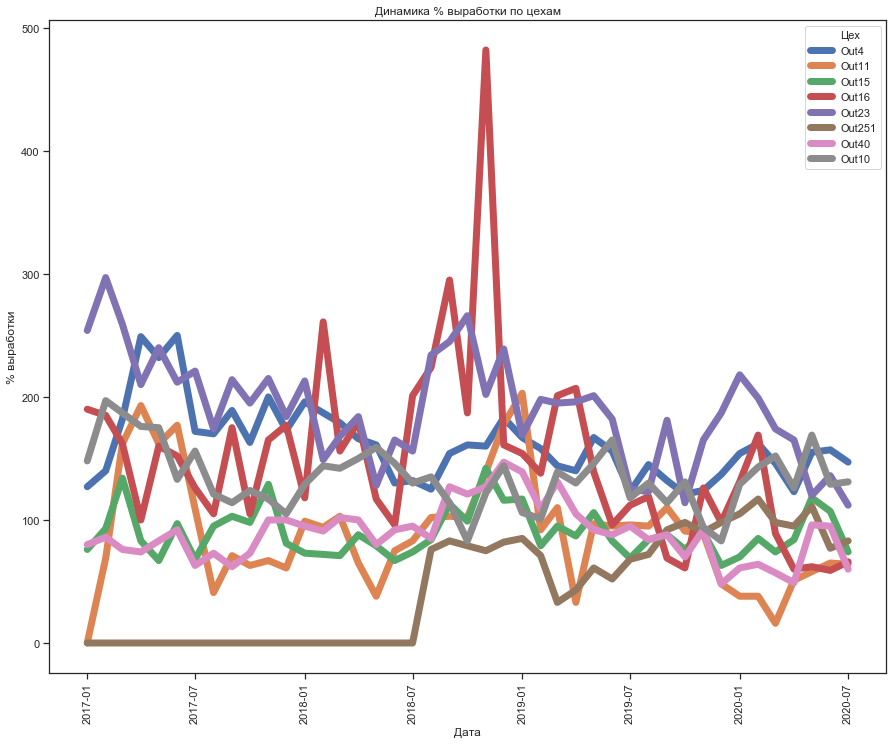

In [185]:
title_output_rot = 'Динамика % выработки по цехам'
plt.figure(figsize=(15, 12))
g = (sns.lineplot(
    x='Дата',
    y='% выработки',
    hue='Цех',
    data = output_rot,
    markers=True,
    dashes=False,
    ci = None)
    .set_title(title_output_rot)
)
sns.set(style="ticks", rc={"lines.linewidth": 5})
plt.xticks(rotation='vertical')

А вот и цель нашего путешествия. Видно, что выработка цехов нечасто падает ниже 100%, что можно считать неплохим результатом. Но для более детального погружения посмотрим на каждый цех отдельно.

#### Выработка цеха 4

(array([736330., 736511., 736695., 736876., 737060., 737241., 737425.,
        737607.]), <a list of 8 Text xticklabel objects>)

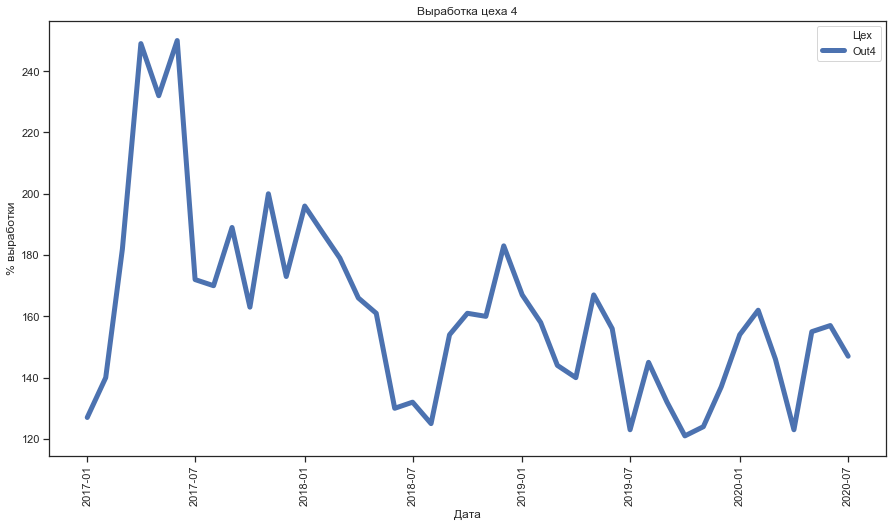

In [186]:
plt.figure(figsize=(15, 8))
g = (sns.lineplot(
    x='Дата',
    y='% выработки',
    hue='Цех',
    data = output_rot[output_rot['Цех'] == 'Out4'],
    markers=True,
    dashes=False,
    ci = None)
    .set_title('Выработка цеха 4')
)
sns.set(style="ticks", rc={"lines.linewidth": 5})
plt.xticks(rotation='vertical')

Выработка цеха 4 никогда не опускается ниже 120%, а в лучшие времена перешагивает за 200! Отличный результат? На самом же деле это связано с особенностями нормирования: так как цех инструментальный и заточен на изготовление оснастки и инструментов для выполнения заказов основных цехов, то один работник может одновременно запустить работу двух и более станков, что, конечно, прекрасно скажется на его личной производительности. Поэтому, как правило, выработка этого цеха редко учитывается в общей картине, а при планировании годовых цифр по трудоемкости акцент ставится на абсолютную сумму нормочасов по месяцам: как мы видели на предыдущих графиках, ежемесячно цех закрывает примерно одинаковый объем в нормочасах почти без привязки к месяцу и численности ОПР.

#### Выработка цеха 11

(array([736330., 736511., 736695., 736876., 737060., 737241., 737425.,
        737607.]), <a list of 8 Text xticklabel objects>)

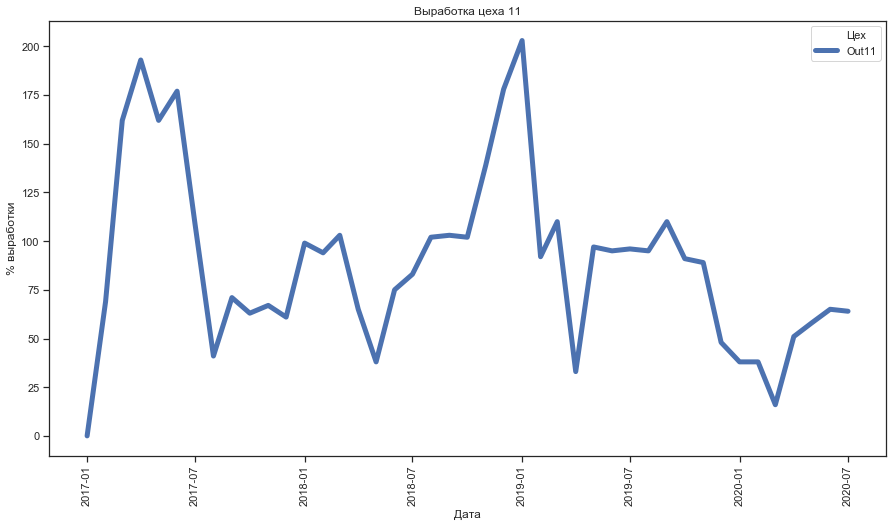

In [187]:
plt.figure(figsize=(15, 8))
g = (sns.lineplot(
    x='Дата',
    y='% выработки',
    hue='Цех',
    data = output_rot[output_rot['Цех'] == 'Out11'],
    markers=True,
    dashes=False,
    ci = None)
    .set_title('Выработка цеха 11')
)
sns.set(style="ticks", rc={"lines.linewidth": 5})
plt.xticks(rotation='vertical')

Цех 11 после возобновления работы начал с места в карьер, но быстро откатился на уровень в лучшем случае около 100%. Помимо стартовых достижений на графике есть лишь один пик, сильно превысивший 100%, который выпал на январь 2019 года. В тот месяц производство должно было закрыть большой заказ, все работали без выходных, на новогодние праздники цеха не останавливались. В остальном цех явно не блещет достижениями. Учитывая, что это один из основных сборочных цехов, такая ситуация требует более глубокого анализа. Возможно, в 2018 году можно было говорить о недостаточной загруженности цеха заказами, но в 2020 году на цех попало немало крайне трудоемких по меркам цеха заказов, поэтому такое падение эффективности в этом году не может радовать.

(array([736330., 736511., 736695., 736876., 737060., 737241., 737425.,
        737607.]), <a list of 8 Text xticklabel objects>)

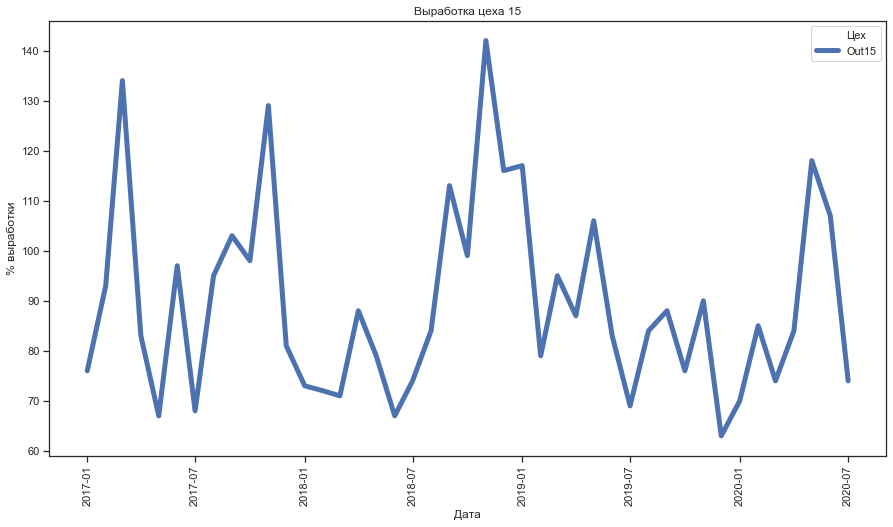

In [188]:
plt.figure(figsize=(15, 8))
g = (sns.lineplot(
    x='Дата',
    y='% выработки',
    hue='Цех',
    data = output_rot[output_rot['Цех'] == 'Out15'],
    markers=True,
    dashes=False,
    ci = None)
    .set_title('Выработка цеха 15')
)
sns.set(style="ticks", rc={"lines.linewidth": 5})
plt.xticks(rotation='vertical')

Цех 15 не отличается стабильностью в плане выработки, и это обстоятельство нельзя объяснить неравномерной загрузкой или частыми перецеховками. Как видно, здесь есть гораздо больше пиков, превышающих 100%, и все они относятся к рубежам годов. При этом в январе 2020 года нового пика не случилось, его пришлось ждать до мая, когда в цех был передан тяжелый заказ с подгорающим сроком отгрузки. Это обстоятельство обнажает первую серьезную проблему загрузки производства: по каким-то причинам выпускающие цеха неравномерно закрывают трудоемкости тяжелых заказов, поэтому во избежание срыва сроков отгрузки приходится авральничать и устраиваться на вынужденные переработки. 

Две ключевые причины, лежащие в основе этих неприятных тенденций, - это срывы сроков предыдущих этапов подготовки производства: 
- конструкторская документация готовится с ощутимым запаздыванием относительно плана, что связано с нехваткой конструкторов и, вероятно, недостаточной вычислительной мощностью техники, которая находится в их распоряжении. Это запаздывание может достигать двух-трех месяцев, и потом, когда в дело вступают заготовительные цеха, они за счет своих переработок несколько наверстывают упущенное время. 

- Еще одна причина - срывы сроков материально-технического обеспечения заказов заготовками, сырьем и прочими материалами. Это обстоятельство сильнее влияет на выполнение заказов в срок. Дело в том, что в 2020 году был поставлен абсолютный антирекорд по срокам поставок на целую группу заказов для атомной промышленности. При плановых сроках поставок от 25 до 75 дней реальные сроки превысили 500 дней (почти два года). С остальными заказами ситуация обстоит лучше, но все равно задержка в три-четыре месяца стала на предприятии совершенно привычным делом. Это также приводит к тому, что первую половину срока изготовления заказа выпускающий цех перебивается тем, что есть, а затем резко взвинчивает темпы изготовления, чтобы уложиться либо не слишком сильно сорвать срок.

(array([736330., 736511., 736695., 736876., 737060., 737241., 737425.,
        737607.]), <a list of 8 Text xticklabel objects>)

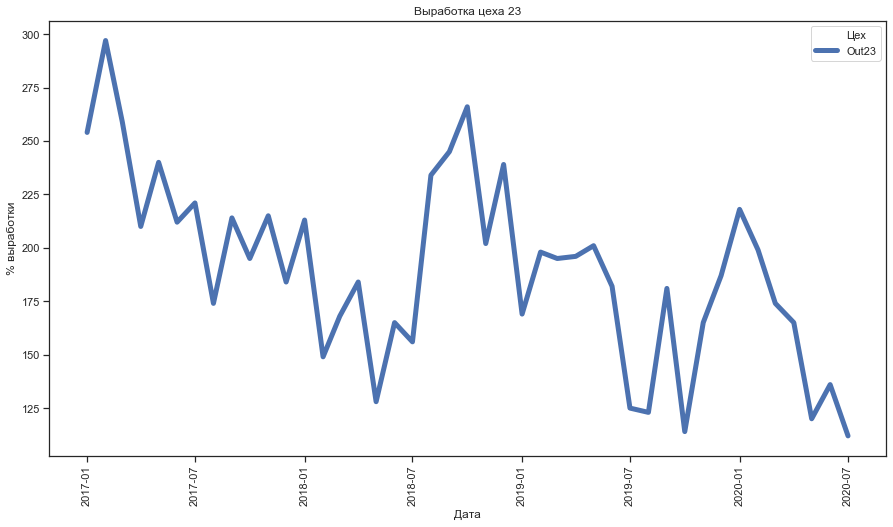

In [189]:
plt.figure(figsize=(15, 8))
g = (sns.lineplot(
    x='Дата',
    y='% выработки',
    hue='Цех',
    data = output_rot[output_rot['Цех'] == 'Out23'],
    markers=True,
    dashes=False,
    ci = None)
    .set_title('Выработка цеха 23')
)
sns.set(style="ticks", rc={"lines.linewidth": 5})
plt.xticks(rotation='vertical')

Интересно, что цех 23 прогрессирующе снижает выработку. Да, она так ни разу и не опустилась ниже 100%, но если в 2017 году она была выше 200%, то далее неуклонно снижается. Выше мы видели, что также снижается и численность цеха, но выработка считается как отношение отработанных нормочасов к фонду рабочего времени, так что это не причина. Здесь нужно копать глубже именно в организации производства. Вероятно, повысилась точность нормирования задач заготовительных цехов.

(array([736330., 736511., 736695., 736876., 737060., 737241., 737425.,
        737607.]), <a list of 8 Text xticklabel objects>)

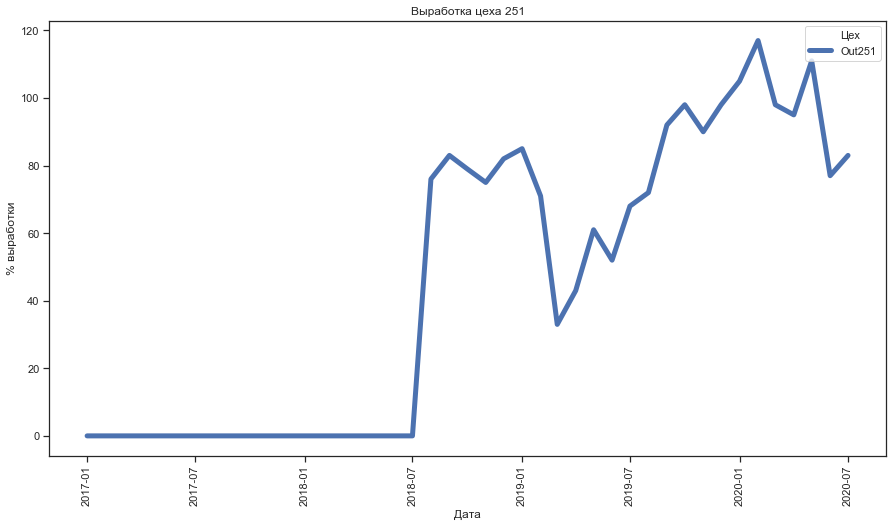

In [190]:
plt.figure(figsize=(15, 8))
g = (sns.lineplot(
    x='Дата',
    y='% выработки',
    hue='Цех',
    data = output_rot[output_rot['Цех'] == 'Out251'],
    markers=True,
    dashes=False,
    ci = None)
    .set_title('Выработка цеха 251')
)
sns.set(style="ticks", rc={"lines.linewidth": 5})
plt.xticks(rotation='vertical')

Как отмечалось выше, цех 251 - сторонняя площадка полного цикла производства, которая вошла в состав завода в августе 2018 года, поэтому более ранних данных по выработке нет. Спад по выработке, пришедшийся на первую половину 2019 года, можно объяснить неизбежной реструктуризацией как портфеля заказов площадки, так и численности ОПР. Закончив заказы, которые были в производстве площадки на момент ее вхождения в новую структуру, цех столкнулся с банальной недозагрузкой, перестав получать множество мелких заказов, которые приходили к нему, когда он был в статусе самостоятельного хозяйствующего субъекта. Параллельно вынужденно была сокращена численность. Но постепенно площадку насытили новыми заказами, численность восстановилась, и вот уже первую половину 2020 года цех встречает переработкой, связанной опять же с потенциальным срывом сроков поставки крупного заказа.

(array([736330., 736511., 736695., 736876., 737060., 737241., 737425.,
        737607.]), <a list of 8 Text xticklabel objects>)

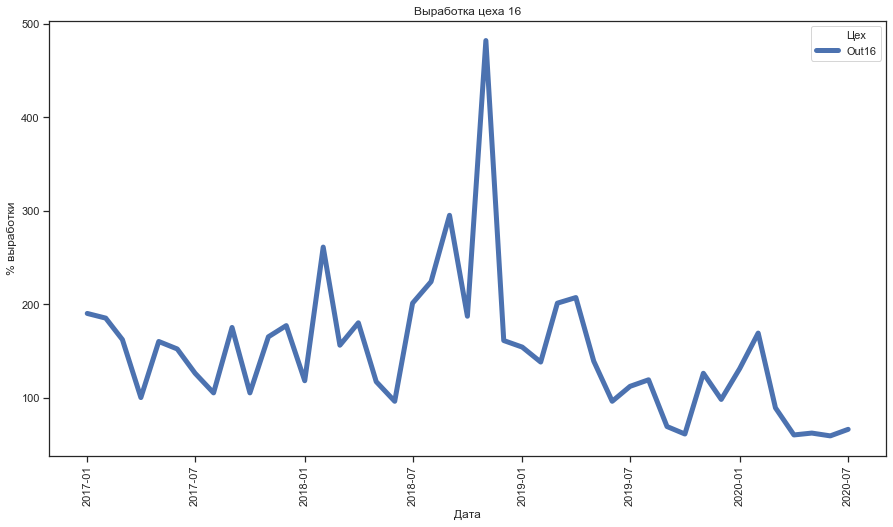

In [191]:
plt.figure(figsize=(15, 8))
g = (sns.lineplot(
    x='Дата',
    y='% выработки',
    hue='Цех',
    data = output_rot[output_rot['Цех'] == 'Out16'],
    markers=True,
    dashes=False,
    ci = None)
    .set_title('Выработка цеха 16')
)
sns.set(style="ticks", rc={"lines.linewidth": 5})
plt.xticks(rotation='vertical')

Цех листовой штамповки вместе с основным своим цехом - 23 - снижает выработку. При этом портфель его заказов не снижается. Зато здесь отчетливо проявляется другая тенденция. Дело в том, что цех 16 штампует огромные количества одинаковых днищ, их настолько много, что это можно считать серийным производством. Одни и те же заказчики ежемесячно разещают в цехе заказы на пачки новых днищ, так что номера комплектов в заказах давно перевалили за 1000 и даже 2000. В таких условиях изготовление каждого следующего комплекта требует меньших усилий. Однако к концу 2020 года можно ожидать нового скачка выработки цеха, поскольку на момент выгрузки рассматриваемых данных в цех зашли несколько новых и крайне трудоемких заказов с нестандартными требованиями к качеству стали. Так что можно предположить, что поставки затянутся, и цех будет серьезно перегружен к концу года, когда придут сроки отгрузки.

(array([736330., 736511., 736695., 736876., 737060., 737241., 737425.,
        737607.]), <a list of 8 Text xticklabel objects>)

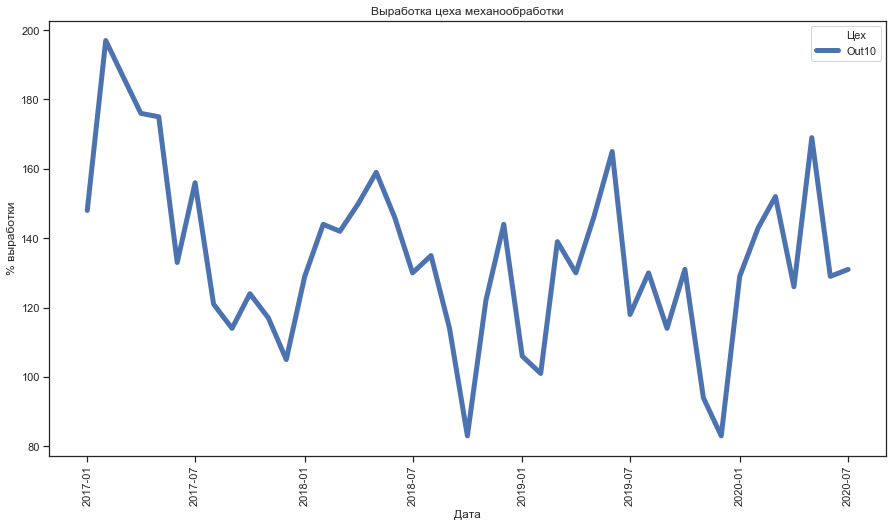

In [192]:
plt.figure(figsize=(15, 8))
g = (sns.lineplot(
    x='Дата',
    y='% выработки',
    hue='Цех',
    data = output_rot[output_rot['Цех'] == 'Out10'],
    markers=True,
    dashes=False,
    ci = None)
    .set_title('Выработка цеха механообработки')
)
sns.set(style="ticks", rc={"lines.linewidth": 5})
plt.xticks(rotation='vertical')

Механообработка впереди планеты всей - выработка стабильно на уровне 120-140%. Это опять же объяснимо особенностями нормирования и тем, что здесь все-таки главным образом работают станки, а не люди, поэтому корректнее было бы считать загрузку механики по оборудованию. 

(array([736330., 736511., 736695., 736876., 737060., 737241., 737425.,
        737607.]), <a list of 8 Text xticklabel objects>)

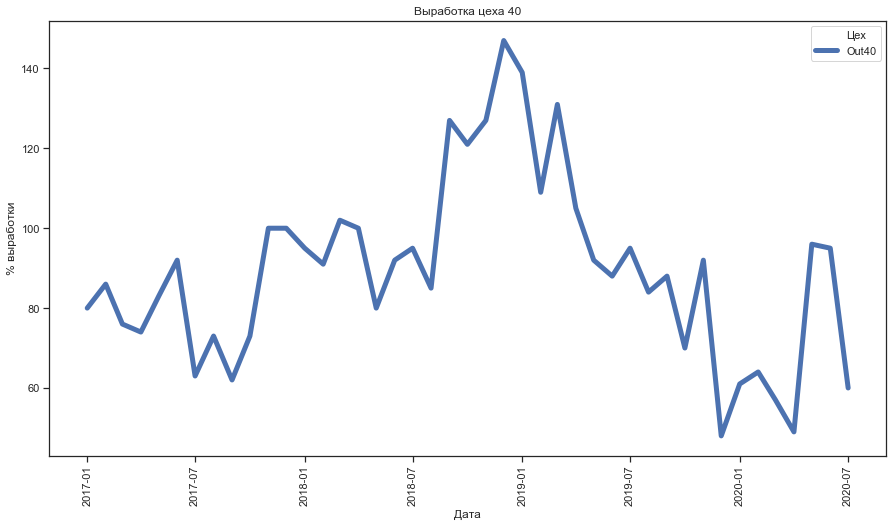

In [193]:
plt.figure(figsize=(15, 8))
g = (sns.lineplot(
    x='Дата',
    y='% выработки',
    hue='Цех',
    data = output_rot[output_rot['Цех'] == 'Out40'],
    markers=True,
    dashes=False,
    ci = None)
    .set_title('Выработка цеха 40')
)
sns.set(style="ticks", rc={"lines.linewidth": 5})
plt.xticks(rotation='vertical')

График самого объемного цеха иллюстрирует тенденции, относящиеся и к другим цехам: неравномерная до скачкообразности выработка, огромный пик на рубеже 2018-19 годов, резкий спад в начале 2020 и возврат к 100% в середине года. Особенность работы цеха 40 такова, что без учета механики работают именно люди, поэтому выработка выше 100% - это скорее исключение, и у таких историй должна быть веская причина. Пик на рубеже 2018-19 годов объяснен выше. В остальное время нормальной выработкой для цеха можно считать уровень между 80 и 90%. Снижение выработки говорит о срывах поставок материалов, выработка выше 100% - об авралах. 

(array([736330., 736511., 736695., 736876., 737060., 737241., 737425.,
        737607.]), <a list of 8 Text xticklabel objects>)

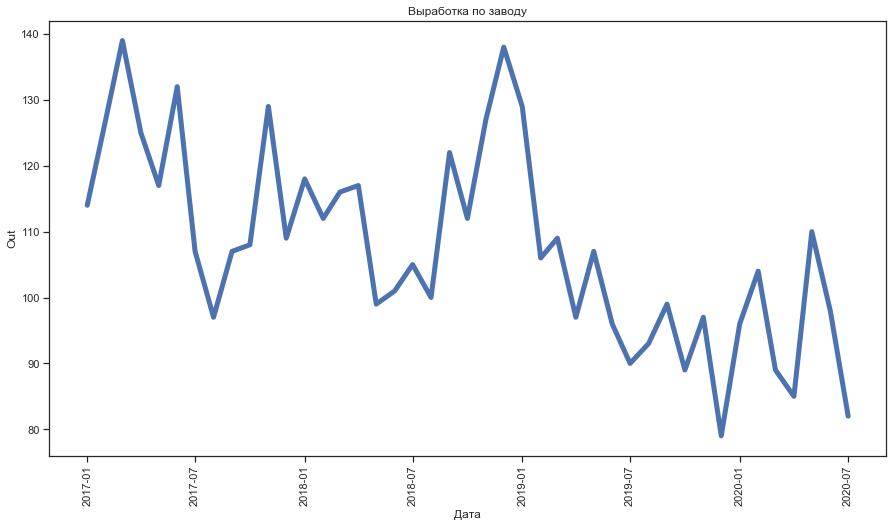

In [194]:
plt.figure(figsize=(15, 8))
g = (sns.lineplot(
    x='Дата',
    y='Out',
    data = output_percent,
    markers=True,
    dashes=False,
    ci = None)
    .set_title('Выработка по заводу')
)
sns.set(style="ticks", rc={"lines.linewidth": 5})
plt.xticks(rotation='vertical')

Увы, картина в целом показывает устойчивое снижение выработки в целом по заводу. За вычетом пика на рубеже 2018-19 годов тенденция скорбная - от в среднем 120% к в среднем 80%. Тем не менее можно предсказать новый рост к концу 2020 года, поскольку на момент выгрузки анализируемых данных поставки, что называется, "прорвало". Как правило, это приводит к резкому росту выработки.

### Выводы 

1. Очевидно, что для завода в целом не проблема уровень выработки выше 100%. Нормальным можно считать уровень между 100 и 120%.
2. Выработка выше нормального уровня свидетельствует о вынужденных авралах, ниже - о срывах сроков поставок и/или разработки конструкторской документации.
3. Заготовительные, инструментальные цеха и площадки механической обработки (цех 16 и мх40, который в этом проекте переименован в цех 10) традиционно демонстрируют выработку существенно выше 100%, что связано с особенностью организации производственных работ на этих площадках: там корректнее считать загрузку по станкам, а не людям, но особенности табельного учета этих работ таковы, что с точки зрения станков там выработка около 100%, а с точки зрения ОПР - сильно выше.
4. Напротив, выпускающие цеха гораздо чувствительнее к непрерывности снабжения и подготовки документации. Для них нормальным уровнем выработки можно считать пределы в 85-95%, поэтому любые отставания предыдущих служб в жизненном цикле проекта косвенно приводят к снижению выработки.
5. Ключевые вызовы, стоящие на пути к выравниванию выработки: 
 - своевременная подготовка конструкторской документации; 
 - полнота подготовки конструкторской документации (снижение объема изменений документации в ходе непосредственного изготовления заказа);
 - своевременные поставки сырья и материалов.
6. Отдельное внимание нужно уделить цеху 15: его выработка более турбулентна, чем у других подразделений.